In [2597]:
import numpy as np

import math

import random

import pandas as pd

import matplotlib.pyplot as plt

import seaborn as sns

from itertools import combinations

from scipy.stats import ttest_ind

import os

from collections import Counter

%matplotlib inline
import warnings; warnings.simplefilter('ignore')

pd.set_option('display.max_rows', 50) # выведем больше строк

pd.set_option('display.max_columns', 50) # выведем больше колонок

print(os.listdir("../input"))
#https://www.pordata.pt/en/DB/Portugal/Search+Environment/Table

['imbd-sf', 'UNICEF_stud_math']


#  Глобальные переменные и функции

In [2598]:

df = pd.read_csv('../input/UNICEF_stud_math/stud_math.csv')
#Глобальные переменные для передачи в df.apply
targetFeature = '' #целевая колонка df, например 'romantic'
filterQuery = '' # условия поиска "похожих" сторк, например '(  ( 45 <= score <= 60) & (age ==15 ) & (higher == 1) & (sex == 0) ) '
N_features ='all' #количество возвращаемых корреляционных коэфф-в "all" - все значимые, 1/2/3/4 - к-во
func ='mostfreq' #функция обработки filterQuery  'mostfreq'/'mean'/'median'


In [2599]:
def changeVal(columnsList, oldVal1, newVal1, oldVal2, newVal2):

    for col in columnsList:
        df[col] = df[col].apply(lambda x: newVal1 if str(x).strip() == oldVal1 and str(x).strip() != oldVal2 else newVal2 if str(x).strip() == oldVal2 and x.strip() != oldVal1 else x)

In [2600]:
changeVal(['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher','internet',	'romantic'],'yes',1,'no',0)
changeVal(['famsize'],'LE3',0,'GT3',1)
changeVal(['Pstatus'],'T',1,'A',0)
changeVal(['address'],'U',1,'R',0)
changeVal(['school'],'GP',1,'MS',0)
changeVal(['sex'],'F',0,'M',1)

In [2601]:
def get_boxplot4Val(column):
    try:
        fig, ax = plt.subplots(figsize = (8, 2))
        df.boxplot(column)
        plt.xticks(rotation=45)
        ax.set_title('Boxplot for ' + column)
        plt.show()
    except:
        return

In [2602]:
def get_his4Val(column, df1=df):
    try:
        fig, ax = plt.subplots(figsize = (14, 4))
        df1[column].hist()
        plt.xticks(rotation=45)
        ax.set_title('Hist for ' + column)
        plt.show()
    except:
        return

In [2603]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=df,#.loc[cacao.loc[:, column].isin(df.loc[:, column].value_counts().index[:10])],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [2604]:
def get_histplot(column, y='score'):
    #fig, ax = plt.subplots(figsize = (14, 4))
    sns.jointplot(x=column, y=y,data=df, kind='reg') 
    # plt.xticks(rotation=45)
    #ax.set_title('Boxplot for ' + column)
    plt.show()

In [2605]:
def get_barplot(column, hue, y='score', func=np.median):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.barplot(y=y, x=column, hue=hue, data=df, estimator=func, ax=ax)

    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + 'column')
    plt.show()

In [2606]:
def get_stat_dif(column): 
    cols = df.loc[:, column].value_counts().index[:]
    combinations_all = list(combinations(cols, 2))
    pvl=[]
    for comb in combinations_all:
        pvalue = ttest_ind(df.loc[df.loc[:, column] == comb[0], 'score'], df.loc[df.loc[:, column] == comb[1], 'score']).pvalue
        pvl.append(pvalue)
        if pvalue <= 0.05/len(combinations_all): # Учли поправку Бонферони
            print('Найдены статистически значимые различия для колонки', column)
            break
    #print(pvl, '---', len(combinations_all))

In [2607]:
def getMainStatistics(column, returnTuple = False, df1=df):
    '''
    Возвращаем:
    perc25 - 1.5*IQR, perc25, IQR, perc75, perc75 + 1.5*IQR, median, mean, minCol, maxCol
    '''
    median = df1[column].median()
    mean = df1[column].mean()
    minCol = df1[column].min()
    maxCol = df1[column].max()
    perc25 = df1[column].quantile(0.25)
    perc75 = df1[column].quantile(0.75)
    IQR = perc75 - perc25

    if returnTuple:
        return perc25 - 1.5*IQR, perc25, IQR, perc75, perc75 + 1.5*IQR, median, mean, minCol, maxCol
    else:
        print(f'--{column}--  perc25 - 1.5*IQR={perc25 - 1.5*IQR}; perc25={perc25}; IQR={IQR}; perc75={perc75}; perc75 + 1.5*IQR ={perc75 + 1.5*IQR}; median={median}; mean={mean}; min={minCol}; max={maxCol}')
        

In [2608]:
def getCorrelationFeatures(col, N_features='all', df1=df):
    #print("N_features ", N_features)
    if df1[col].dtypes == 'O':
        return None
    r_limit = np.round(2/(np.sqrt(len(df1.index))),2)

    r = round(df1.corr(),2)

    if N_features=='all':
        N_features = len(r)
    else:
        N_features+=1

    r_ser=(r[ (( r > 0)&(r >= r_limit)) | (( r < 0)&(r <= -r_limit))][col].dropna())#.index
    r_ser=r_ser.reindex(r_ser.abs().sort_values(ascending = False).index)[:N_features]
    #r_NamesList=r_ser.index#[:N_features]

    return r_ser

In [2609]:
#test
getCorrelationFeatures(col='romantic')

romantic    1.00
score      -0.14
age         0.14
higher     -0.13
sex        -0.13
internet    0.10
failures    0.10
Name: romantic, dtype: float64

In [2610]:
def calcNumbFeature(groupbyList, filterQuery, targetFeature, func='mean', silent=False):
    res=np.NaN
    grouped_df=df.groupby(groupbyList)['age'].count().to_frame(name="count").reset_index().query(filterQuery)
    rowsCount = 0
    occurences = 0
    if (len(grouped_df.index) > 0):
        rowsCount = len(grouped_df.index)
        if func == 'mean':
            res = pd.Series(sum(grouped_df[targetFeature])/sum(grouped_df['count']))
        elif func == 'median':
            res = pd.Series(grouped_df[targetFeature].median())         
        elif func == 'mostfreq':
            ggdf=grouped_df.dropna(subset=[targetFeature]).groupby(targetFeature).sum().reset_index()
            # display(ggdf)
            # display(ggdf[ggdf['count'] == ggdf['count'].max()][targetFeature] )
            # print('------------')
            occurences =ggdf['count'].max()
            res =  pd.Series(ggdf[ggdf['count'] == ggdf['count'].max()][targetFeature])
        else:
            res=pd.Series(np.NaN)
    else:
        print('Ничего не нашли похожего')
        res = pd.Series(df.dropna(subset=[targetFeature])[targetFeature].value_counts().idxmax())
        #print(res)
    if silent == False:
        print(f'Выбрано {rowsCount} строк; Случаев {occurences};  Значение для {targetFeature}={res.values.round()}')
        display(grouped_df)
        print('-------------------------------------------------------')
    return res.values.round()

In [2677]:

calcNumbFeature(groupbyList=['Pstatus', 'absences', 'Fedu', 'famrel', 'guardian'], filterQuery='(-3.0 <= absences <= 15.0) & (Fedu == 1.0) & (famrel == 2.0) & (guardian == "mother")', targetFeature='Pstatus',  func='mostfreq', silent=False)

Выбрано 3 строк; Случаев 2; Значение для Pstatus=[1.]


,Pstatus,absences,Fedu,famrel,guardian,count
9,0.0,5.0,1.0,2.0,mother,1
54,1.0,2.0,1.0,2.0,mother,1
69,1.0,3.0,1.0,2.0,mother,1


-------------------------------------------------------


array([1.])

In [2676]:
#test
calcNumbFeature(groupbyList=['romantic',  'score', 'age', 'higher', 'sex', 'internet',
       'failures'], filterQuery='(   (score >= 0) & (age >= 17 ) & (higher == 1) & (sex == 1) & (internet == 0)) ', targetFeature='romantic',  func='mostfreq', silent=False)[0]

Выбрано 8 строк; Случаев 8; Значение для romantic=[0.]


,romantic,score,age,higher,sex,internet,failures,count
4,0.0,0.0,17,1.0,1,0.0,0.0,1
12,0.0,0.0,19,1.0,1,0.0,1.0,1
53,0.0,45.0,20,1.0,1,0.0,2.0,1
68,0.0,50.0,17,1.0,1,0.0,0.0,1
72,0.0,50.0,18,1.0,1,0.0,0.0,1
99,0.0,60.0,18,1.0,1,0.0,0.0,1
107,0.0,65.0,17,1.0,1,0.0,0.0,1
140,0.0,90.0,20,1.0,1,0.0,0.0,1


-------------------------------------------------------


0.0

In [2613]:
def calc_Feature_basedOnSimilarity():#(targetFeature,filterQuery, func='mostfreq', N_features=5, df1=df):
    corrS = getCorrelationFeatures(col=targetFeature, N_features=N_features)
    #print(corrS, N_features)
    return calcNumbFeature( corrS.index.tolist(), filterQuery, targetFeature, func, silent=False)#[0]


In [2678]:
#test
targetFeature = 'romantic'
filterQuery ='(   (score >= 55) & (age >= 17 ) & (higher == 1) & (sex == 1) & (internet == 0)   ) ' #
N_features = 15

func = 'mostfreq'

calc_Feature_basedOnSimilarity()


UndefinedVariableError: name 'internet' is not defined

In [2615]:
def calc_Feature_basedOnSimilarityROW(row):
    if not pd.isna(row[targetFeature]): return row[targetFeature]
    corrS = getCorrelationFeatures(col=targetFeature, N_features=N_features)
    return calcNumbFeature(corrS.index.tolist(), filterQuery, targetFeature, func, silent=True)[0]
    #row[targetFeature] = calcNumbFeature(corrS.index.tolist(), filterQuery, targetFeature, func, silent=True)[0]

In [2616]:
# targetFeature = 'romantic'
# filterQuery ='(  ( 45 <= score <= 60) & (age ==15 ) & (higher == 1) & (sex == 0) ) '
# filter4TargetGroup = '(age == 15 )'
# N_features = 'all'
# func = 'mostfreq'
def updateFeature(targetFeatureIn,filter4TargetGroupIn, filterQueryIn, funcIn = 'mostfreq', N_featuresIn = 'all', displayHist=False ):
    '''
    Пакетное обновление выбранных строк, изменение заданных значений столбцов (targetFeatureIn) по принципу поиска похожих строк

    targetFeatureIn -- целевая колонка df, например 'romantic'
    filter4TargetGroupIn -- фильтр для группы записей к которым применяется изменение заданных значений столбцов, например '(age == 15 )'
    filterQueryIn -- условия поиска "похожих" сторк, например '(  ( 45 <= score <= 60) & (age ==15 ) & (higher == 1) & (sex == 0) ) '
    N_features -- количество возвращаемых корреляционных коэфф-в, например "all" - все значимые, 1/2/3/4 - к-во
    func -- функция обработки filterQuery, например 'mostfreq'/'mean'/'median'
    displayHist -- отрисовывать гистограммы распреления признака ДО и ПОСЛЕ обработки
    '''
    print(f'БЫЛО {targetFeatureIn} NaN = {len(df[pd.isna(df[targetFeatureIn])].index)}') 
  
    if displayHist: 
        display(getCorrelationFeatures(col=targetFeatureIn))
        get_his4Val(targetFeatureIn)

    global targetFeature
    targetFeature = targetFeatureIn

    global filterQuery
    filterQuery = filterQueryIn

    global N_features
    N_features = N_featuresIn


    df_TargetGroup=df[pd.isna(df[targetFeatureIn])].query(filter4TargetGroupIn)
    df[targetFeatureIn].update(df_TargetGroup.apply(calc_Feature_basedOnSimilarityROW, axis=1))

    if displayHist:
        display(getCorrelationFeatures(col=targetFeatureIn))
        get_his4Val(targetFeatureIn)

    print(f'СТАЛО {targetFeatureIn} NaN = {len(df[pd.isna(df[targetFeatureIn])].index)}')

In [2617]:
#test
# targetFeature = 'romantic'
# filterQuery ='(  ( 45 <= score <= 60) & (age ==15 ) & (higher == 1) & (sex == 0) ) '
# filter4TargetGroup = '(age == 15 )'
# N_features = 'all'
# func = 'mostfreq'

#updateFeature(targetFeatureIn = 'romantic',filter4TargetGroupIn = '(age == 15 )', filterQueryIn = '(  ( 45 <= score <= 60) & (age ==15 ) & (higher == 1) & (sex == 0) ) ', funcIn = 'mostfreq', N_featuresIn = 'all', displayHist=False )

--------------------------------------------------------
#  Ищем потенциальные вылеты и странности, оцениваем распределение

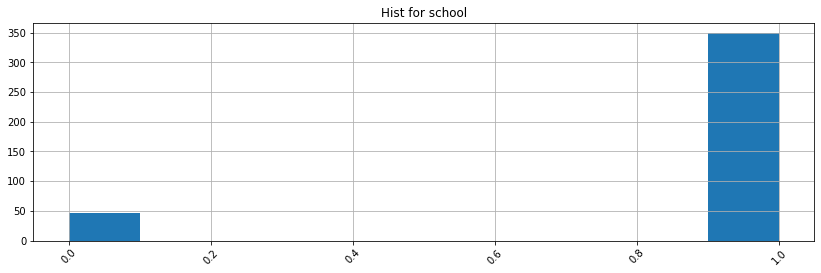

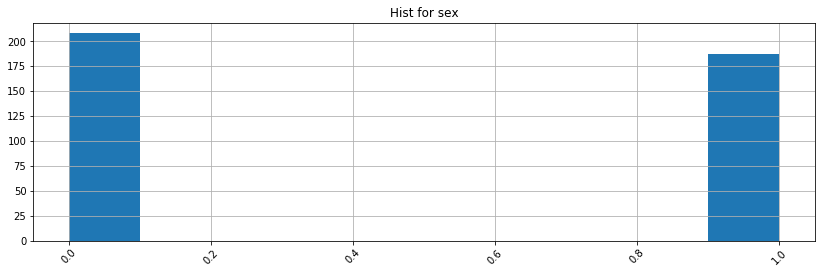

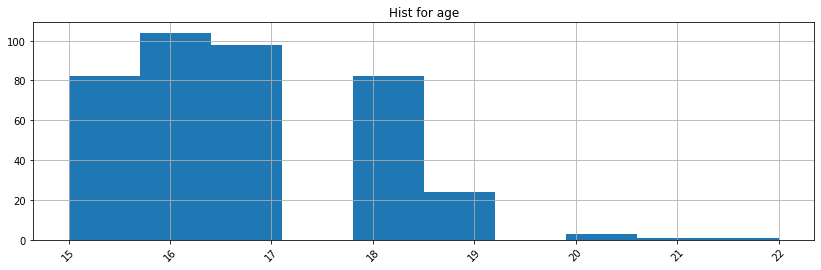

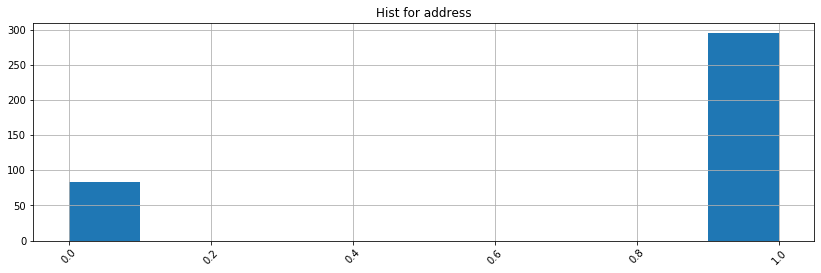

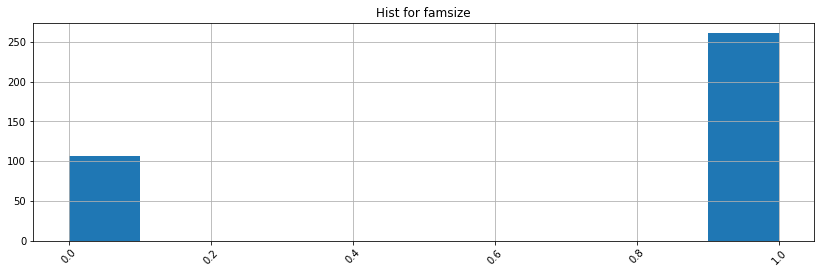

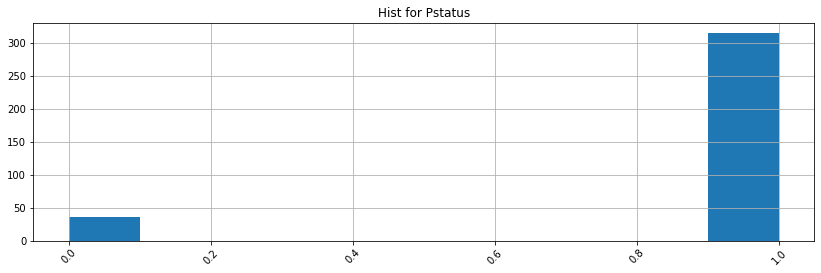

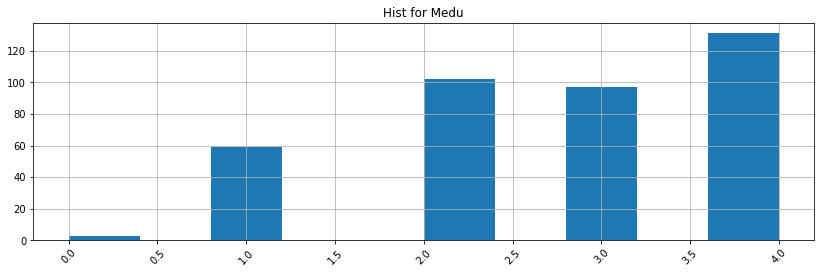

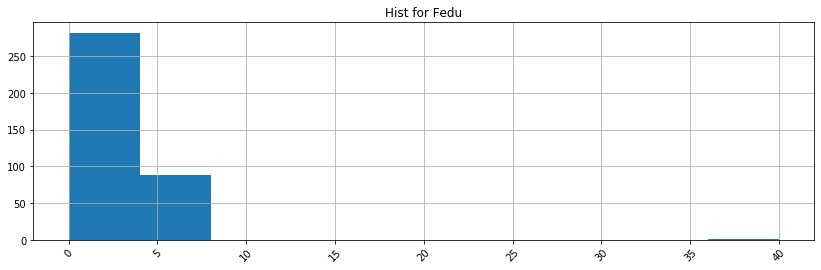

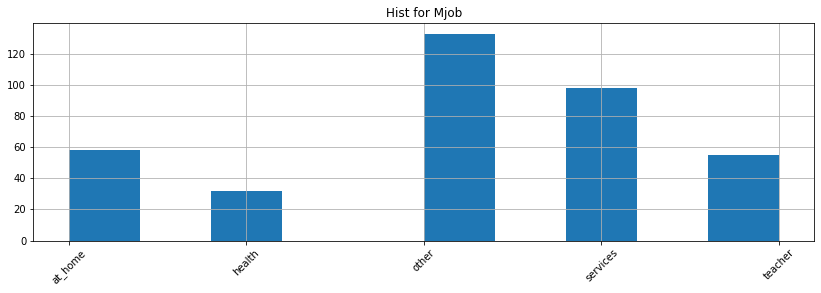

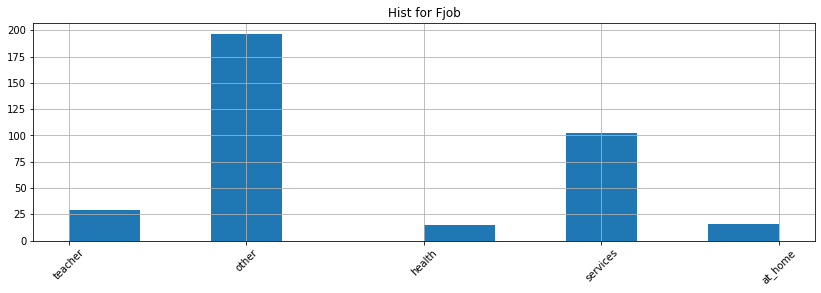

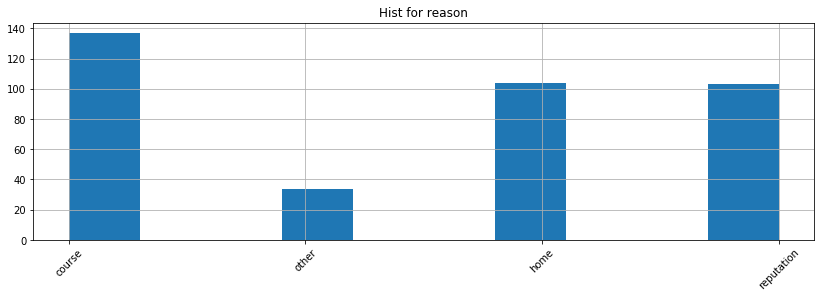

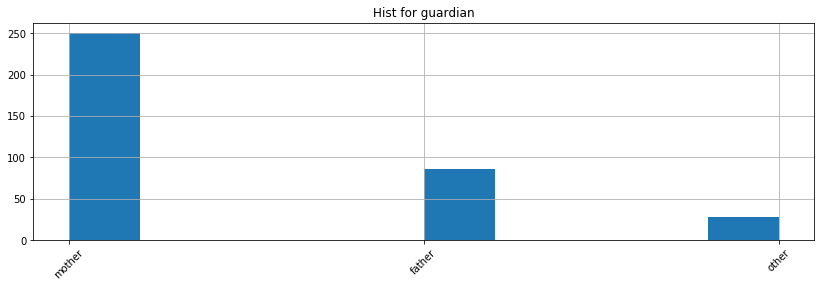

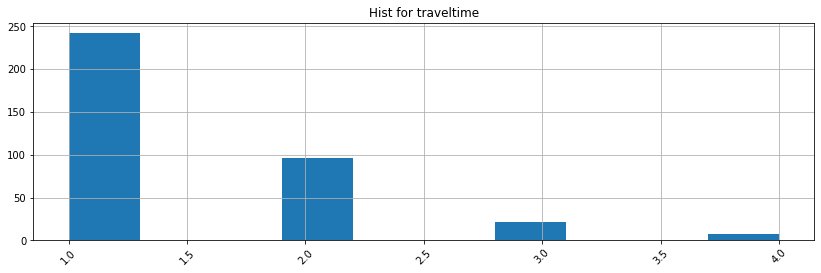

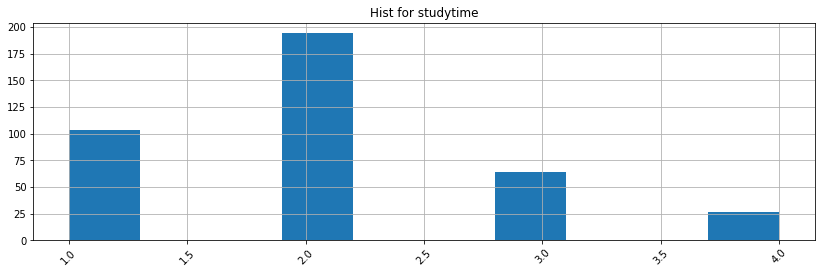

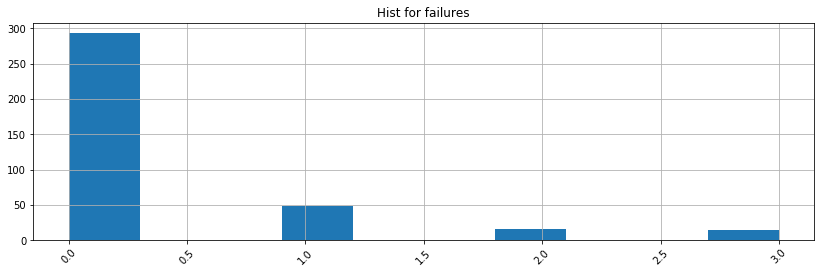

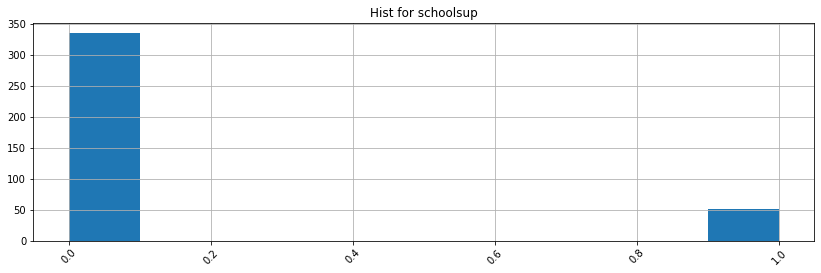

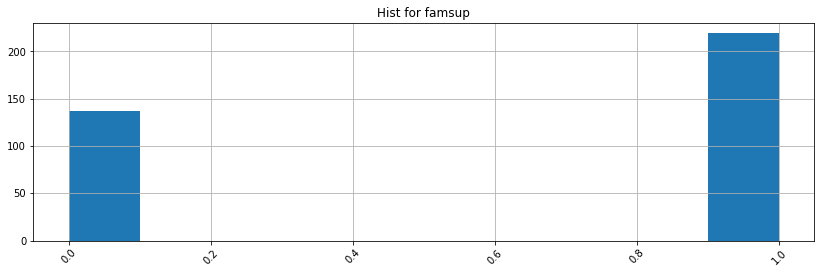

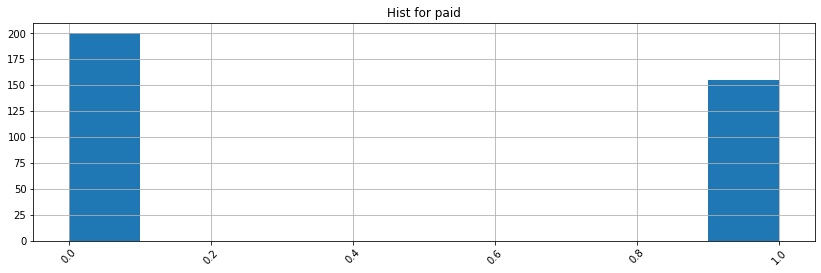

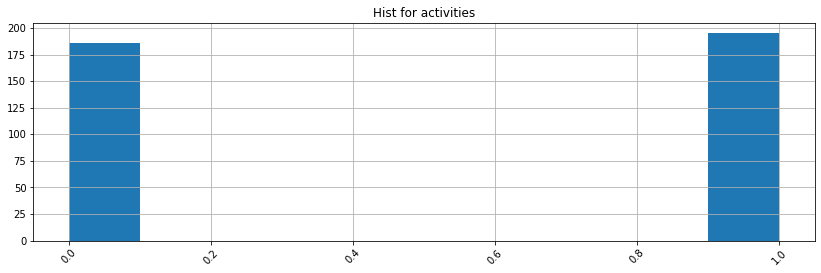

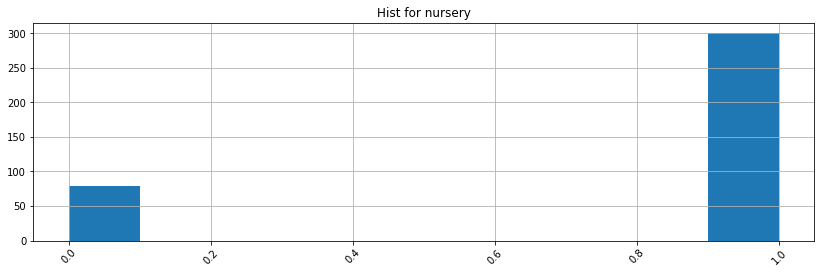

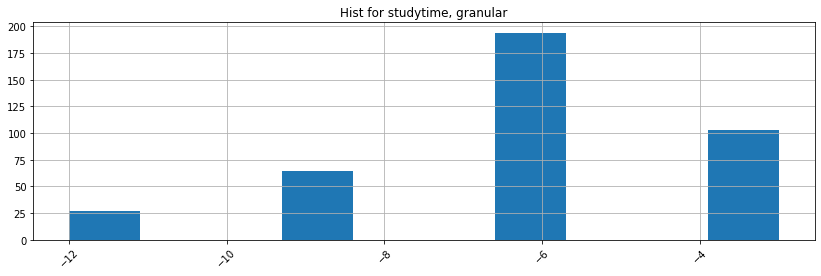

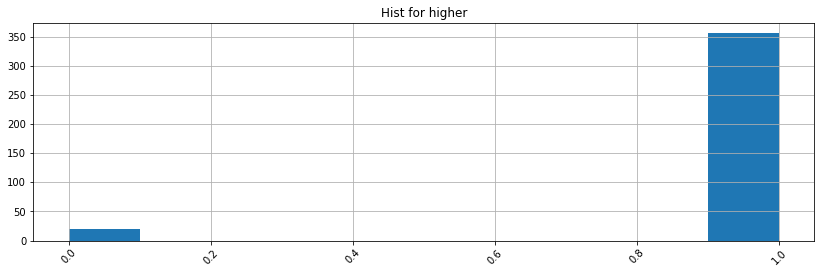

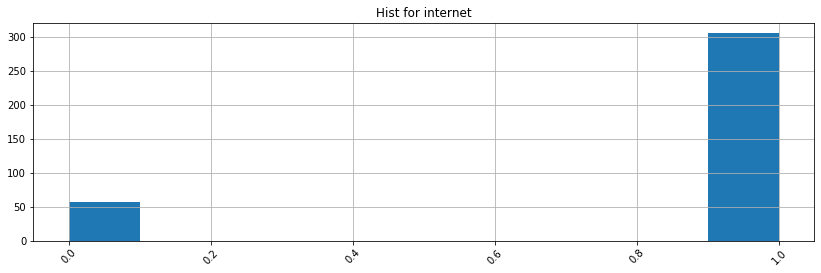

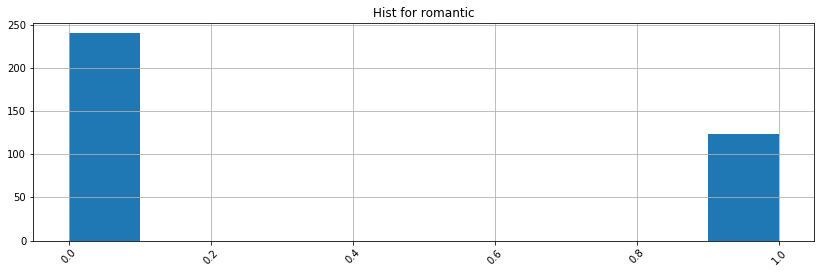

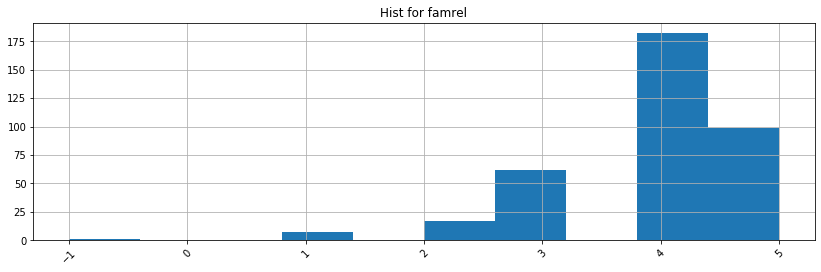

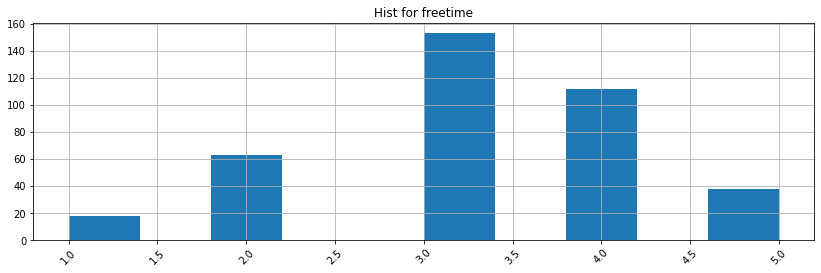

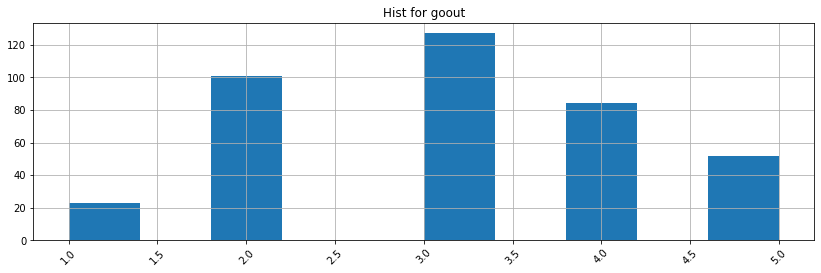

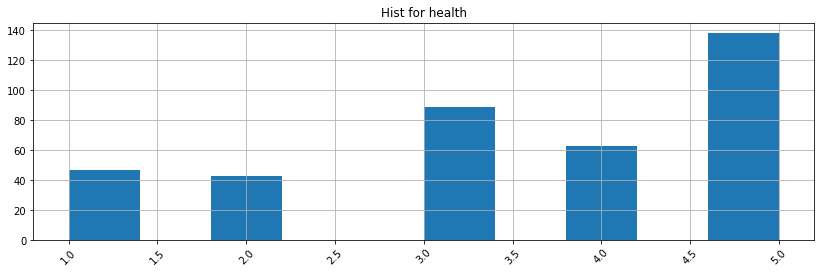

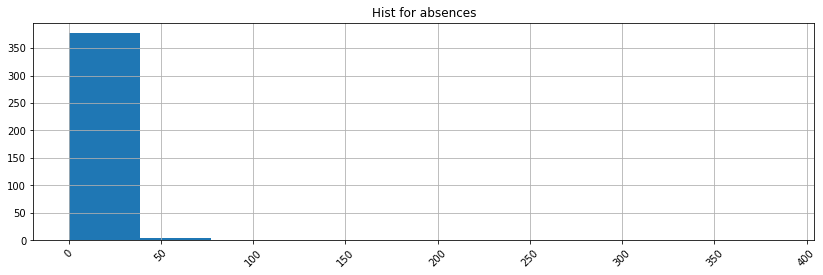

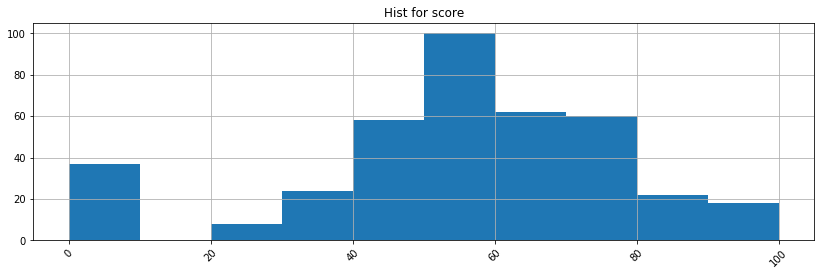

In [2618]:
#Ищем потенциальные вылеты и странности, оцениваем распределение и пропорции - done!
for col in df.columns:
    get_his4Val(col)

In [2619]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
school                 395 non-null int64
sex                    395 non-null int64
age                    395 non-null int64
address                378 non-null float64
famsize                368 non-null float64
Pstatus                350 non-null float64
Medu                   392 non-null float64
Fedu                   371 non-null float64
Mjob                   376 non-null object
Fjob                   359 non-null object
reason                 378 non-null object
guardian               364 non-null object
traveltime             367 non-null float64
studytime              388 non-null float64
failures               373 non-null float64
schoolsup              386 non-null float64
famsup                 356 non-null float64
paid                   355 non-null float64
activities             381 non-null float64
nursery                379 non-null float64
studytime, granular    38

In [2620]:
#Убираем вылет по Образованию отца, принимаем, что ошиблись при вводе. ввели 40 д.б. 4.0 Уровень образования 0-оставляем т.к. он есть в классификации и встречается в жизни. 
df.loc[df.Fedu == 40,'Fedu'] = 4


--age--  perc25 - 1.5*IQR=13.0; perc25=16.0; IQR=2.0; perc75=18.0; perc75 + 1.5*IQR =21.0; median=17.0; mean=16.696202531645568; min=15; max=22


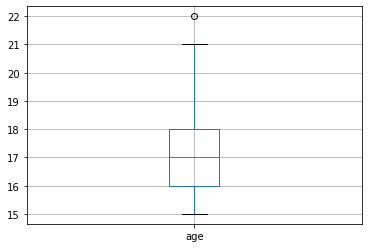

In [2621]:
df.boxplot('age')
getMainStatistics('age')

df.age >18 #Старше 18 лет 29чел. 7% от общего числа и все похожи на "живых людей"

In [2622]:
#famrel Есть 1 выброс -1 - предполагаем, что ошибка ввода или так плохо в семье :) - назначаем наиболее логичное значение 
df.loc[df.famrel < 1,'famrel'] = 1


--absences--  perc25 - 1.5*IQR=-12.0; perc25=0.0; IQR=8.0; perc75=8.0; perc75 + 1.5*IQR =20.0; median=4.0; mean=7.2793733681462145; min=0.0; max=385.0


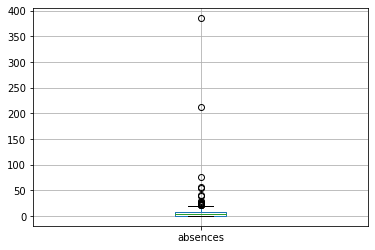

In [2623]:
df.boxplot('absences')
getMainStatistics('absences')
#df[df.absences > 20]

Вылетов (всё что больше perc75 + 1.5*IQR) всего 4.3% Если исходить из того, что чебный год в США длится, как правило, 170-186 дней и absences - это количество пропущенных ЛЮБЫХ учебных занятий, то даже 385 занятий - это 2-3 пропущенных занятия в день. Логичных причин может быть много, например освобождение от занятий в связи с домашним обучением и/или результатами или просто прогулами, таких всего 0.5%. 

Для упрощения понимания общей картины, всё равно заменим  "вылеты" более 75 на медианное значение. 

absences подверглось обработке  0.51 %
--absences--  perc25 - 1.5*IQR=-12.0; perc25=0.0; IQR=8.0; perc75=8.0; perc75 + 1.5*IQR =20.0; median=4.0; mean=5.741514360313316; min=0.0; max=75.0


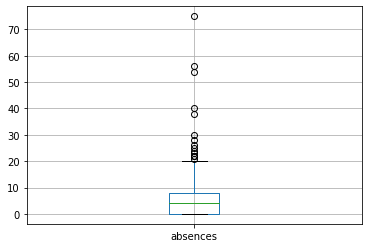

In [2624]:
print('absences подверглось обработке ',round(len(df[df.absences > 75])/len(df.index) * 100,2),'%') #20
 
df.loc[df.absences > 75,'absences'] = df.absences.median() #20
df.boxplot('absences')
getMainStatistics('absences')

-------------------------------------------------------------------------------
#  Здесь нужно разобраться руками -- отработка технологии

In [2625]:

display(df.loc[ (df.index!=-1) & (pd.isna(df.address)) & ( (pd.isna(df.internet)) | (pd.isna(df.traveltime)) | (pd.isna(df.failures)) | (pd.isna(df.Medu)) | (pd.isna(df.score)) )])
df.loc[ (df.index==92) , ['address','Medu']]=[0, 1] # по всем признакам это address=R, Medu=1 для этой группы образования

df.loc[ (df.index==52) , ['address','Fjob', 'famsup', 'internet']]=[0, 'other', 0, 0] # по всем признакам это address=R, Fjob=other исходя из Образование, работа матери + образование отца для выяснениия возможной работы отца, famsup =0 т.к. разведенные родители, ребенок живет с отцом, отец с невысоким уровнем образования

df.loc[ (df.index==241) , ['address','traveltime', 'goout']]=[1, 1, 3] # по всем признакам это address=U traveltime =1 как самое распространенное для U; df[(df.freetime==3) & (df.age==17)].groupby([ 'freetime', 'age', 'score', 'failures', 'internet','goout'])['age'].count() - 3 для goout

df.loc[ (df.index==270) , ['address','score', 'goout', 'score']]=[1, 1, 3, 30]

df.loc[ (df.index==348) , ['address','famrel']]=[1, 4] #calcNumbFeature(groupbyList=['famrel', 'freetime', 'age', 'sex'], filterQuery=' (freetime ==4) & (age == 17) & (sex == 0) ', targetFeature='famrel',  func='mostfreq', silent=False)[0]

df.loc[ (df.index==350) , ['address','nursery', 'score']]=[0, 0, 50]  

df.loc[ (df.index==372) , ['address','traveltime', 'romantic']]=[1, 1, 0] 
print (len(df.loc[ (df.index!=-1) & (pd.isna(df.address)) & ( (pd.isna(df.internet)) | (pd.isna(df.traveltime)) | (pd.isna(df.failures)) | (pd.isna(df.Medu)) | (pd.isna(df.score)) )].index))

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
52,1,1,15,NaN,0.0,0.0,4.0,2.0,health,NaN,other,father,2.0,1.0,1.0,0.0,NaN,0.0,0.0,1.0,-3.0,1.0,NaN,0.0,5.0,5.0,5.0,5.0,6.0,50.0
92,1,0,16,NaN,0.0,1.0,NaN,1.0,other,other,home,father,1.0,2.0,0.0,1.0,1.0,0.0,0.0,1.0,-6.0,1.0,0.0,0.0,3.0,3.0,NaN,2.0,4.0,30.0
241,1,1,17,NaN,0.0,0.0,4.0,4.0,teacher,other,course,mother,NaN,2.0,0.0,0.0,1.0,1.0,0.0,1.0,-6.0,1.0,1.0,0.0,3.0,3.0,NaN,4.0,2.0,60.0
270,1,0,19,NaN,1.0,1.0,3.0,3.0,other,services,home,other,1.0,2.0,2.0,0.0,1.0,1.0,1.0,1.0,-6.0,1.0,1.0,0.0,4.0,3.0,5.0,5.0,NaN,NaN
348,1,0,17,NaN,1.0,1.0,4.0,3.0,health,other,reputation,mother,NaN,3.0,0.0,0.0,1.0,1.0,1.0,1.0,-9.0,1.0,1.0,1.0,NaN,4.0,3.0,4.0,0.0,75.0
350,0,1,19,NaN,1.0,1.0,1.0,1.0,other,services,home,other,3.0,2.0,3.0,0.0,0.0,0.0,0.0,NaN,-6.0,1.0,1.0,0.0,5.0,4.0,4.0,2.0,8.0,NaN
372,0,0,17,NaN,1.0,1.0,2.0,2.0,other,at_home,home,mother,NaN,3.0,0.0,0.0,0.0,0.0,1.0,1.0,-9.0,1.0,0.0,NaN,3.0,4.0,3.0,3.0,8.0,55.0


0


------------------------------------------------------------------
#  Устраняем NaN в romantic

In [2626]:
targetFeature = 'romantic'
display(df[pd.isna(df[targetFeature])]) # & (df.age == 18) & (df.sex == 1)
getCorrelationFeatures(col=targetFeature)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
2,1,0,15,1.0,0.0,1.0,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,1.0,0.0,NaN,0.0,1.0,-6.0,1.0,1.0,NaN,4.0,3.0,2.0,3.0,10.0,50.0
13,1,1,15,1.0,1.0,1.0,4.0,3.0,teacher,other,course,mother,2.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,-6.0,1.0,1.0,NaN,5.0,4.0,3.0,3.0,2.0,55.0
26,1,1,15,1.0,1.0,1.0,2.0,2.0,other,NaN,home,mother,NaN,1.0,0.0,0.0,1.0,NaN,0.0,1.0,-3.0,1.0,1.0,NaN,4.0,2.0,2.0,5.0,2.0,55.0
27,1,1,15,1.0,1.0,1.0,4.0,2.0,health,services,other,mother,1.0,1.0,0.0,NaN,0.0,1.0,0.0,1.0,-3.0,1.0,1.0,NaN,2.0,2.0,4.0,1.0,4.0,75.0
41,1,1,15,1.0,0.0,1.0,4.0,4.0,teacher,other,home,NaN,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,-3.0,1.0,1.0,NaN,5.0,4.0,3.0,5.0,8.0,60.0
51,1,0,15,1.0,0.0,1.0,4.0,2.0,health,other,other,mother,1.0,2.0,0.0,0.0,NaN,NaN,0.0,1.0,-6.0,1.0,1.0,NaN,4.0,3.0,3.0,5.0,2.0,65.0
54,1,0,15,1.0,0.0,NaN,3.0,3.0,NaN,other,other,mother,1.0,1.0,NaN,0.0,0.0,1.0,NaN,1.0,-3.0,1.0,1.0,NaN,5.0,3.0,4.0,1.0,6.0,65.0
67,1,0,16,1.0,1.0,NaN,3.0,NaN,services,other,course,mother,1.0,4.0,0.0,1.0,1.0,1.0,0.0,1.0,-12.0,1.0,1.0,NaN,4.0,3.0,3.0,5.0,4.0,30.0
75,1,1,15,NaN,1.0,1.0,4.0,3.0,teacher,other,home,mother,1.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,-6.0,1.0,1.0,NaN,NaN,3.0,3.0,5.0,6.0,50.0
112,1,0,16,1.0,1.0,NaN,2.0,2.0,at_home,other,NaN,mother,NaN,NaN,1.0,1.0,0.0,0.0,1.0,1.0,NaN,1.0,1.0,NaN,3.0,1.0,2.0,5.0,6.0,65.0


romantic    1.00
absences    0.15
score      -0.14
age         0.14
higher     -0.13
sex        -0.13
internet    0.11
failures    0.10
Name: romantic, dtype: float64

БЫЛО romantic NaN = 30


romantic    1.00
absences    0.15
score      -0.14
age         0.14
higher     -0.13
sex        -0.13
internet    0.11
failures    0.10
Name: romantic, dtype: float64

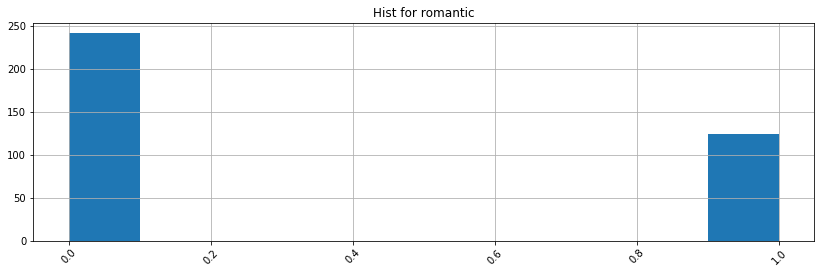

romantic    1.00
absences    0.15
age         0.15
score      -0.14
higher     -0.13
sex        -0.12
internet    0.10
Name: romantic, dtype: float64

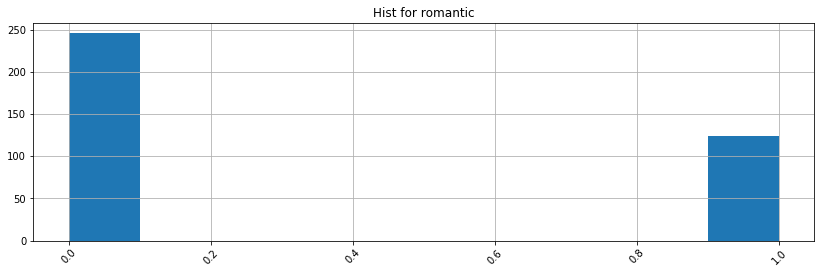

СТАЛО romantic NaN = 25


In [2627]:
updateFeature(targetFeatureIn = 'romantic',filter4TargetGroupIn = '(age == 15 ) & (sex == 0)', filterQueryIn = '(  ( 45 <= score <= 60) & (age ==15 ) & (higher == 1) & (sex == 0) & (internet == 1) ) ', funcIn = 'mostfreq', N_featuresIn = 'all', displayHist=True )

БЫЛО romantic NaN = 25


romantic    1.00
absences    0.15
age         0.15
score      -0.14
higher     -0.13
sex        -0.12
internet    0.10
Name: romantic, dtype: float64

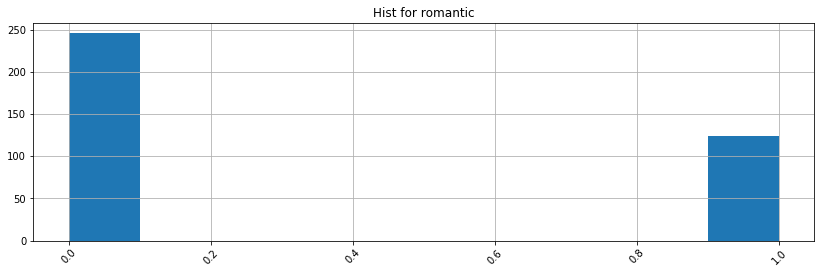

romantic    1.00
age         0.17
absences    0.15
score      -0.14
higher     -0.14
sex        -0.13
internet    0.10
failures    0.10
Name: romantic, dtype: float64

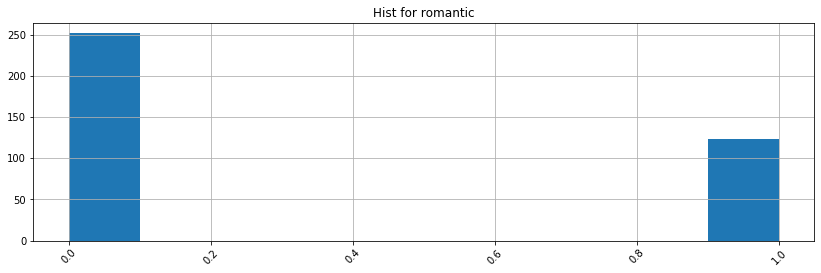

СТАЛО romantic NaN = 19


In [2628]:
updateFeature(targetFeatureIn = 'romantic',filter4TargetGroupIn = '(age == 15 ) & (sex == 1)', filterQueryIn = '(  ( 45 <= score <= 60) & (age ==15 ) & (higher == 1) & (sex == 1) ) ', funcIn = 'mostfreq', N_featuresIn = 'all', displayHist=True )


БЫЛО romantic NaN = 19


romantic    1.00
age         0.17
absences    0.15
score      -0.14
higher     -0.14
sex        -0.13
internet    0.10
failures    0.10
Name: romantic, dtype: float64

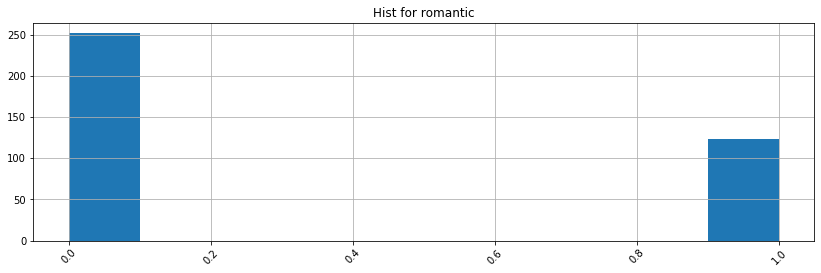

romantic    1.00
age         0.17
absences    0.15
score      -0.14
higher     -0.14
sex        -0.13
Name: romantic, dtype: float64

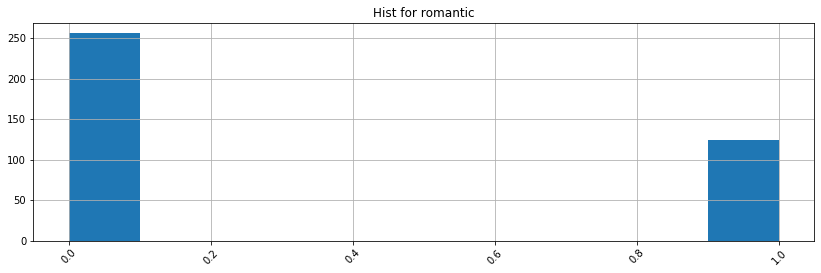

СТАЛО romantic NaN = 15


In [2629]:
updateFeature(targetFeatureIn = 'romantic',filter4TargetGroupIn = '(age == 16 ) & (sex == 0)', filterQueryIn = '(  ( 30 <= score <= 55) & (age ==16 ) & (higher == 1) & (sex == 0) ) ', funcIn = 'mostfreq', N_featuresIn = 'all', displayHist=True )

БЫЛО romantic NaN = 15


romantic    1.00
age         0.17
absences    0.15
score      -0.14
higher     -0.14
sex        -0.13
Name: romantic, dtype: float64

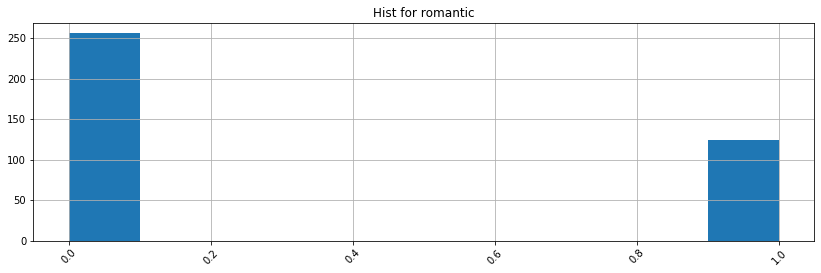

romantic    1.00
age         0.17
absences    0.15
score      -0.14
higher     -0.14
sex        -0.13
Name: romantic, dtype: float64

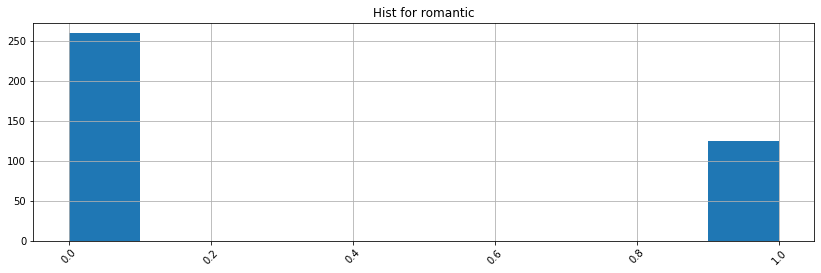

СТАЛО romantic NaN = 12


In [2630]:
updateFeature(targetFeatureIn = 'romantic',filter4TargetGroupIn = '(age == 16 ) & (sex == 1)', filterQueryIn = '(  ( 0 <= score <= 55) & (age ==16 ) & (higher == 1) & (sex == 1) ) ', funcIn = 'mostfreq', N_featuresIn = 'all', displayHist=True )

БЫЛО romantic NaN = 12


romantic    1.00
age         0.17
absences    0.15
score      -0.14
higher     -0.14
sex        -0.13
Name: romantic, dtype: float64

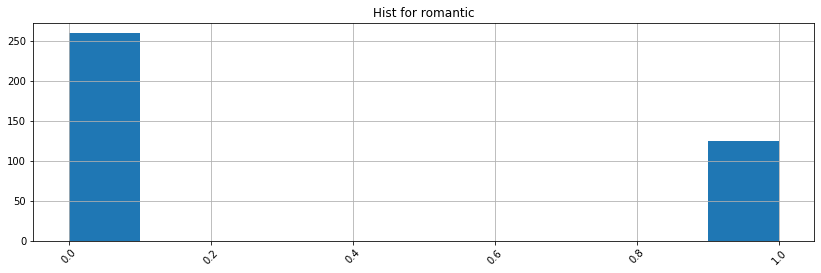

romantic    1.00
age         0.17
absences    0.15
score      -0.14
higher     -0.14
sex        -0.12
failures    0.10
Name: romantic, dtype: float64

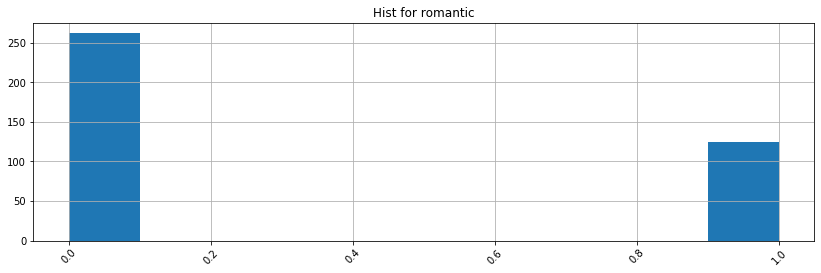

СТАЛО romantic NaN = 9


In [2631]:
updateFeature(targetFeatureIn = 'romantic',filter4TargetGroupIn = '(age == 17 ) & (sex == 0)', filterQueryIn = '(  ( 30 <= score <= 80) & (age ==17 ) & (higher == 1) & (sex == 0) ) ', funcIn = 'mostfreq', N_featuresIn = 'all', displayHist=True )

БЫЛО romantic NaN = 9


romantic    1.00
age         0.17
absences    0.15
score      -0.14
higher     -0.14
sex        -0.12
failures    0.10
Name: romantic, dtype: float64

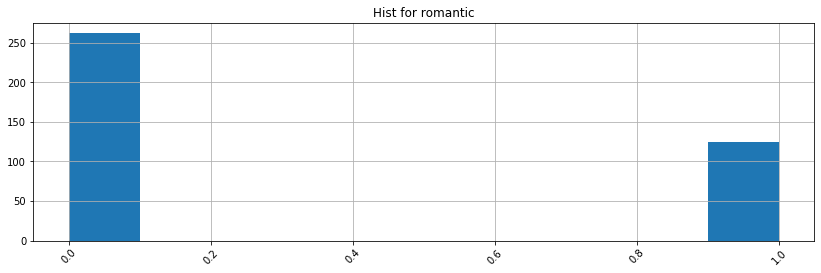

romantic    1.00
age         0.17
score      -0.14
absences    0.14
higher     -0.14
sex        -0.13
failures    0.10
Name: romantic, dtype: float64

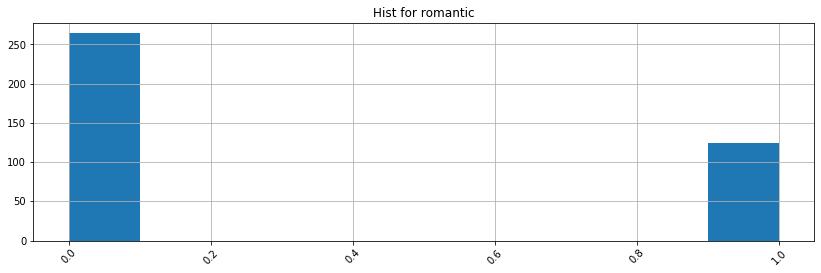

СТАЛО romantic NaN = 7


In [2632]:
updateFeature(targetFeatureIn = 'romantic',filter4TargetGroupIn = '(age == 17 ) & (sex == 1)', filterQueryIn = '(  ( 30 <= score <= 80) & (age ==17 ) & (higher == 1) & (sex == 1) & ( 0 <= failures <=2 )) ', funcIn = 'mostfreq', N_featuresIn = 'all', displayHist=True )

БЫЛО romantic NaN = 7


romantic    1.00
age         0.17
score      -0.14
absences    0.14
higher     -0.14
sex        -0.13
failures    0.10
Name: romantic, dtype: float64

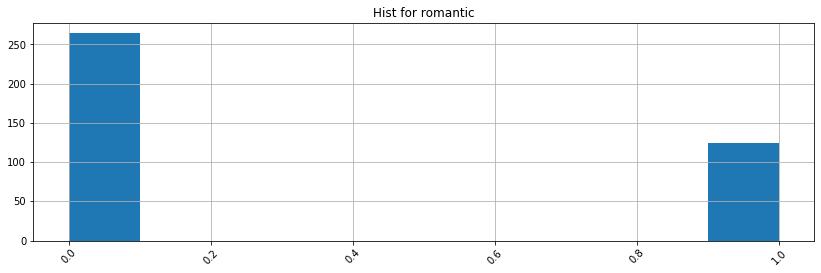

romantic    1.00
age         0.16
absences    0.14
sex        -0.14
score      -0.13
higher     -0.13
failures    0.10
Name: romantic, dtype: float64

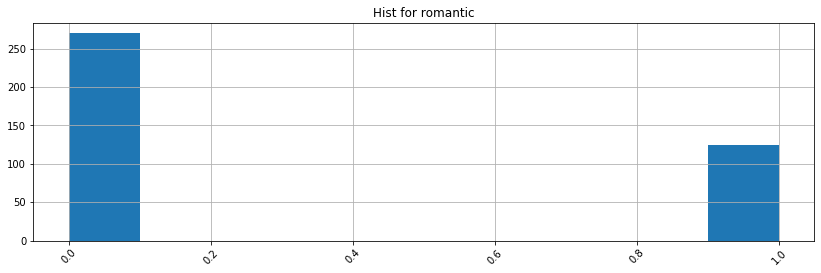

СТАЛО romantic NaN = 1


In [2633]:
updateFeature(targetFeatureIn = 'romantic',filter4TargetGroupIn = '(age == 18 ) & (sex == 1)', filterQueryIn = '(  ( 30 <= score <= 80) & (age ==18 ) & (higher == 1) & (sex == 1) & ( 0 <= failures <=1 )) ', funcIn = 'mostfreq', N_featuresIn = 'all', displayHist=True )

БЫЛО romantic NaN = 1


romantic    1.00
age         0.16
absences    0.14
sex        -0.14
score      -0.13
higher     -0.13
failures    0.10
Name: romantic, dtype: float64

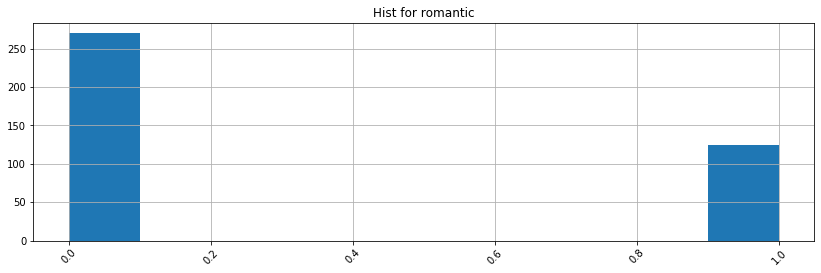

romantic    1.00
absences    0.15
age         0.15
sex        -0.14
score      -0.13
higher     -0.13
failures    0.10
Name: romantic, dtype: float64

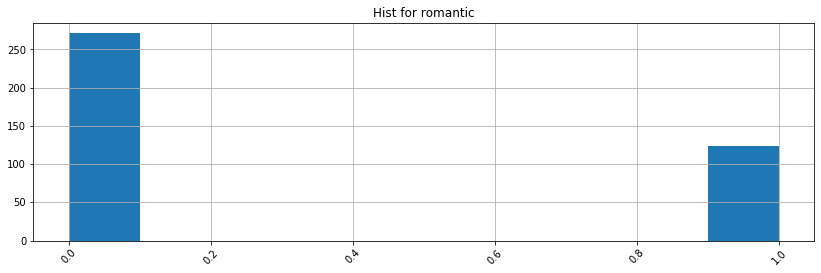

СТАЛО romantic NaN = 0


In [2634]:
updateFeature(targetFeatureIn = 'romantic',filter4TargetGroupIn = '(age == 19 ) & (sex == 1)', filterQueryIn = '(  ( 55 <= score <= 70) & (age ==19 ) & (higher == 1) & (sex == 1) & ( 0 <= failures <=1 )) ', funcIn = 'mostfreq', N_featuresIn = 'all', displayHist=True )

In [2635]:
if len(df[pd.isna(df[targetFeature])].index) == 0 : print(f'Все NaN в "{targetFeature}" успешно заменены.')


Все NaN в "romantic" успешно заменены.


--------------------------------------------------------------


#  Устраняем NaN в famsize 
Промежуточные выводы:
1. Живущие <i>вместе</i> родители с образованием одного из родителей (или обоих) хуже чем "2" (менее 5-9 классов), скорее всего имеют одного ребенка -- LE3 0 Вероятно, бюджет не позволяет, НО до люмпен-пролетариата ещё не дошло т.к ребенок ходит в школу. </br>  
2. Portugal Average family size 2015 --2019 2.5
https://www.pordata.pt/en/Portugal/Average+private+households+size+-511
Т.о., для группы живущих <i>вместе</i> родителей (т.к. 2.5 ближе к 3) принимаем пропущенные значения famsize = 'LE3' 0  
<!--3. Для учеников имеющих родителей живущих порознь, важен параметр absences, при значении 9 и выше принимаем пропущенные famsize значения = 'LE3'. По всей видимости, ребенком некому заниматься-->  




In [2636]:
targetFeature = 'famsize'
display(df[pd.isna(df[targetFeature])]) # & (df.age == 18) & (df.sex == 1)
getCorrelationFeatures(col=targetFeature)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,1,0,18,1.0,NaN,0.0,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,-6.0,1.0,NaN,0.0,4.0,3.0,4.0,3.0,6.0,30.0
9,1,1,15,1.0,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,0.0,1.0,1.0,1.0,1.0,-6.0,1.0,1.0,0.0,5.0,5.0,1.0,5.0,0.0,75.0
32,1,1,15,0.0,NaN,1.0,4.0,3.0,teacher,at_home,course,mother,1.0,2.0,0.0,0.0,1.0,0.0,1.0,NaN,-6.0,1.0,1.0,1.0,4.0,NaN,2.0,5.0,0.0,80.0
36,1,1,15,1.0,NaN,1.0,4.0,3.0,teacher,services,home,mother,1.0,3.0,0.0,0.0,1.0,0.0,1.0,1.0,-9.0,1.0,1.0,0.0,5.0,4.0,3.0,4.0,2.0,90.0
76,1,1,15,1.0,NaN,1.0,4.0,0.0,teacher,other,course,mother,2.0,4.0,0.0,0.0,0.0,0.0,1.0,1.0,-12.0,NaN,1.0,0.0,3.0,4.0,3.0,1.0,8.0,50.0
78,1,1,17,1.0,NaN,1.0,2.0,1.0,other,other,home,mother,2.0,1.0,3.0,1.0,NaN,0.0,1.0,1.0,-3.0,0.0,1.0,0.0,4.0,5.0,1.0,3.0,2.0,50.0
79,1,0,16,1.0,NaN,1.0,3.0,4.0,at_home,other,course,mother,1.0,2.0,0.0,NaN,1.0,0.0,0.0,1.0,-6.0,1.0,1.0,0.0,2.0,4.0,3.0,3.0,12.0,25.0
114,1,1,15,0.0,NaN,1.0,2.0,1.0,health,services,reputation,mother,1.0,2.0,NaN,0.0,0.0,0.0,1.0,1.0,-6.0,1.0,1.0,1.0,5.0,4.0,2.0,5.0,8.0,45.0
128,1,1,18,0.0,NaN,1.0,2.0,2.0,NaN,other,reputation,mother,1.0,1.0,2.0,0.0,1.0,0.0,1.0,1.0,-3.0,1.0,1.0,0.0,3.0,3.0,3.0,4.0,0.0,0.0
129,1,1,16,0.0,NaN,1.0,4.0,4.0,teacher,teacher,course,mother,1.0,NaN,0.0,0.0,0.0,1.0,1.0,1.0,NaN,1.0,1.0,0.0,3.0,5.0,5.0,4.0,NaN,90.0


famsize    1.00
famsup     0.13
nursery   -0.11
sex       -0.10
Name: famsize, dtype: float64

1. Живущие вместе родители с образованием одного из родителей хуже чем "2" (менее 5-9 классов), скорее всего имеют одного ребенка LE

In [2637]:
df.loc[((pd.isna(df.famsize)) & (df.Pstatus == 1)) & ((df.Medu <=2) | (df.Fedu <= 2)),'famsize'] = 0#'LE3'

2. Т.к. с 1960г по 2019г средняя Американская семья больше 3-х человек, например в 2019г. == 3.14 https://www.statista.com/statistics/183657/average-size-of-a-family-in-the-us/ То, для группы живущих вместе родителей (т.к. уже 3 человека минимум есть) принимаем пропущенные значения famsize = 'GT3'

In [2638]:
df.loc[(pd.isna(df.famsize)) & ( df.Pstatus == 1),'famsize'] =0#'LE3'

Всего 4 записи №№[9, 252, 268, 313] с NAN famsize & Pstatus, непонятно что с ними делать, будет рандом.
Также заполняем оставшиеся 3 famsize значениеми из следующей строки

In [2639]:
f=df[(pd.isna(df.famsize)) & (pd.isna(df.Pstatus))].index

df.iloc[f, df.columns.get_loc('famsize')] = random.choice([1, 0])
df.iloc[f, df.columns.get_loc('Pstatus')] = random.choice([1, 0])
df['famsize'].fillna( method ='bfill', inplace = True) 


In [2640]:
if len(df[pd.isna(df[targetFeature])].index) == 0 : print(f'Все NaN в "{targetFeature}" успешно заменены.')

Все NaN в "famsize" успешно заменены.


---------------------------------------------------------------------------------
#  Устраняем NaN в address

In [2641]:
targetFeature = 'address'
getCorrelationFeatures(col=targetFeature, df1=df)

address       1.00
traveltime   -0.29
school        0.28
internet      0.22
Medu          0.16
age          -0.14
score         0.12
failures     -0.12
Fedu          0.10
Name: address, dtype: float64

In [2642]:
df[pd.isna(df[targetFeature])].groupby([ 'traveltime', 'school', 'internet', 'Medu'])['age'].count()

traveltime  school  internet  Medu
1.0         1       1.0       2.0     4
                              3.0     1
                              4.0     1
2.0         0       1.0       1.0     1
                              4.0     2
            1       1.0       4.0     1
Name: age, dtype: int64

In [2643]:
df[pd.isna(df[targetFeature])][['address', 'traveltime', 'school', 'internet', 'Medu', 'age', 'score',
       'failures', 'Fedu']]

,address,traveltime,school,internet,Medu,age,score,failures,Fedu
6,NaN,1.0,1,1.0,2.0,16,55.0,0.0,2.0
75,NaN,1.0,1,1.0,4.0,15,50.0,0.0,3.0
96,NaN,2.0,1,1.0,4.0,16,75.0,0.0,3.0
159,NaN,1.0,1,1.0,3.0,16,60.0,1.0,NaN
168,NaN,1.0,1,1.0,2.0,16,0.0,0.0,2.0
254,NaN,1.0,1,1.0,2.0,17,60.0,0.0,1.0
292,NaN,1.0,1,1.0,2.0,18,65.0,1.0,1.0
354,NaN,2.0,0,1.0,4.0,17,55.0,0.0,3.0
359,NaN,2.0,0,1.0,1.0,18,80.0,0.0,1.0
376,NaN,2.0,0,1.0,4.0,20,75.0,2.0,2.0


In [2644]:
print (f'U={len(df[df.address==1].index)} R={len(df[df.address==0].index)}')

U=299 R=86


БЫЛО address NaN = 10


address       1.00
traveltime   -0.29
school        0.28
internet      0.22
Medu          0.16
age          -0.14
score         0.12
failures     -0.12
Fedu          0.10
Name: address, dtype: float64

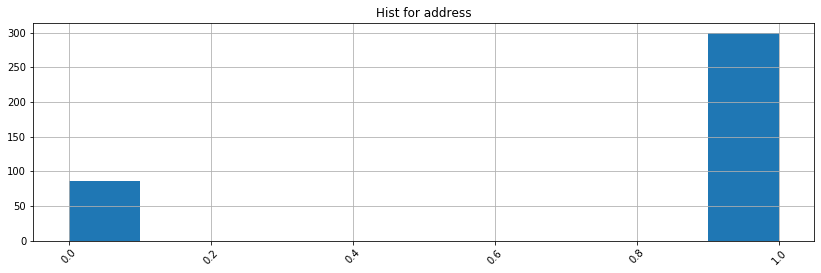

address       1.00
traveltime   -0.30
school        0.29
internet      0.22
Medu          0.16
age          -0.14
score         0.12
failures     -0.12
Fedu          0.10
Name: address, dtype: float64

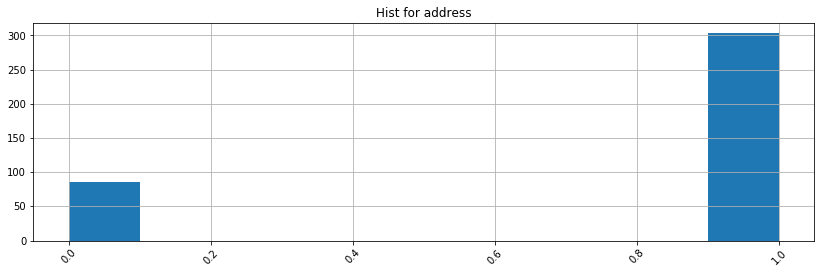

СТАЛО address NaN = 6


In [2645]:
updateFeature(targetFeatureIn = 'address',filter4TargetGroupIn = '(traveltime == 1 ) & (school == 1) & (internet == 1) & ( 45 <= score <= 60)  ', filterQueryIn = '(traveltime == 1 ) & (school == 1) & (internet == 1) & ( 45 <= score <= 60)  ', funcIn = 'mostfreq', N_featuresIn = 'all', displayHist=True )

In [2646]:
#updateFeature(targetFeatureIn = 'address',filter4TargetGroupIn = '(traveltime == 1 ) & (school == 1) & (internet == 1) & ( 45 <= score <= 60)  ', filterQueryIn = '(traveltime == 1 ) & (school == 1) & (internet == 1) & ( 45 <= score <= 60)  ', funcIn = 'mostfreq', N_featuresIn = 'all', displayHist=True )

БЫЛО address NaN = 6


address       1.00
traveltime   -0.30
school        0.29
internet      0.22
Medu          0.16
age          -0.14
score         0.12
failures     -0.12
Fedu          0.10
Name: address, dtype: float64

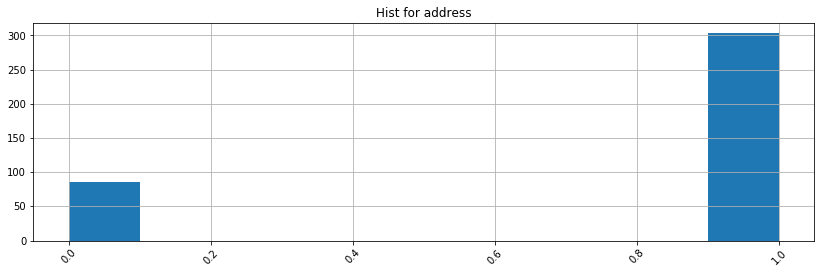

address       1.00
traveltime   -0.30
school        0.29
internet      0.22
Medu          0.16
age          -0.14
score         0.12
failures     -0.12
Fedu          0.10
Name: address, dtype: float64

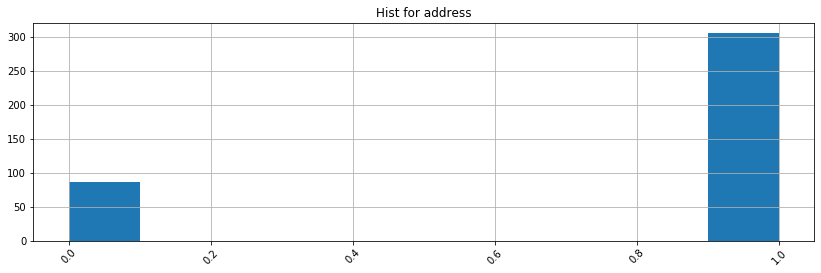

СТАЛО address NaN = 4


In [2647]:
updateFeature(targetFeatureIn = 'address',filter4TargetGroupIn = '(traveltime == 1 ) & (school == 1) & (internet == 1) & ( Medu == 2)  ', filterQueryIn = '(traveltime == 1 ) & (school == 1) & (internet == 1) & ( Medu == 2)', funcIn = 'mostfreq', N_featuresIn = 'all', displayHist=True )

In [2648]:
#updateFeature(targetFeatureIn = 'address',filter4TargetGroupIn = '(traveltime == 1 ) & (school == 1) & (internet == 1) & ( Medu == 2)  ', filterQueryIn = '(traveltime == 1 ) & (school == 1) & (internet == 1) & ( Medu == 2)', funcIn = 'mostfreq', N_featuresIn = 'all', displayHist=True )

БЫЛО address NaN = 4


address       1.00
traveltime   -0.30
school        0.29
internet      0.22
Medu          0.16
age          -0.14
score         0.12
failures     -0.12
Fedu          0.10
Name: address, dtype: float64

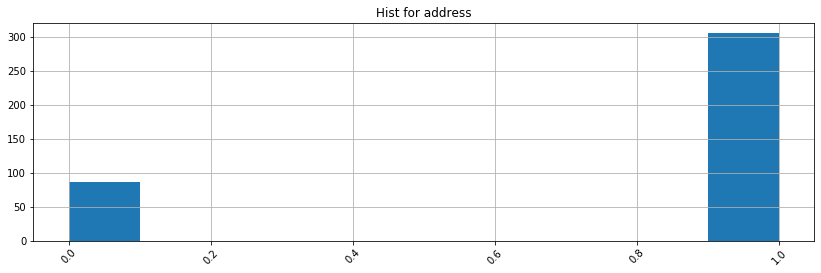

address       1.00
traveltime   -0.30
school        0.28
internet      0.23
Medu          0.16
age          -0.14
score         0.12
failures     -0.12
Name: address, dtype: float64

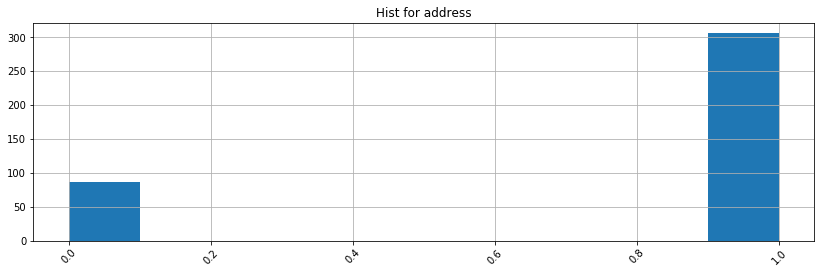

СТАЛО address NaN = 3


In [2649]:
updateFeature(targetFeatureIn = 'address',filter4TargetGroupIn = '(traveltime == 2 ) & (school == 0) & (internet == 1) & ( Medu == 1)  ', filterQueryIn = '(traveltime == 2 ) & (school == 0) & (internet == 1) & ( Medu == 1)', funcIn = 'mostfreq', N_featuresIn = 'all', displayHist=True )

БЫЛО address NaN = 3


address       1.00
traveltime   -0.30
school        0.28
internet      0.23
Medu          0.16
age          -0.14
score         0.12
failures     -0.12
Name: address, dtype: float64

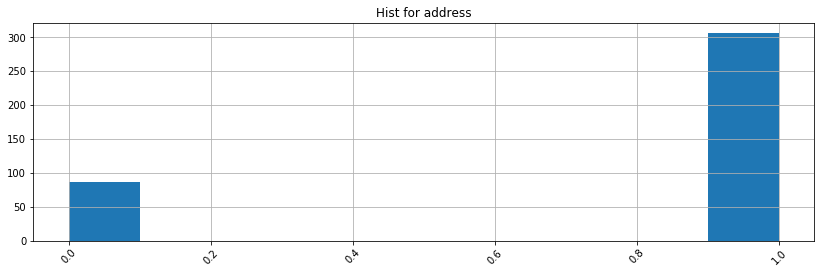

address       1.00
traveltime   -0.30
school        0.30
internet      0.22
age          -0.15
Medu          0.14
score         0.12
failures     -0.12
Name: address, dtype: float64

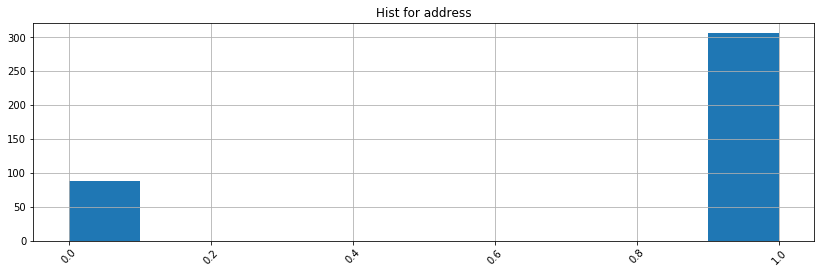

СТАЛО address NaN = 1


In [2650]:
updateFeature(targetFeatureIn = 'address',filter4TargetGroupIn = '(traveltime == 2 ) & (school == 0) & (internet == 1) & ( Medu == 4)  ', filterQueryIn = '(traveltime == 2 ) & (school == 0) & (internet == 1) & ( Medu == 4) ', funcIn = 'mostfreq', N_featuresIn = 'all', displayHist=True )

БЫЛО address NaN = 1


address       1.00
traveltime   -0.30
school        0.30
internet      0.22
age          -0.15
Medu          0.14
score         0.12
failures     -0.12
Name: address, dtype: float64

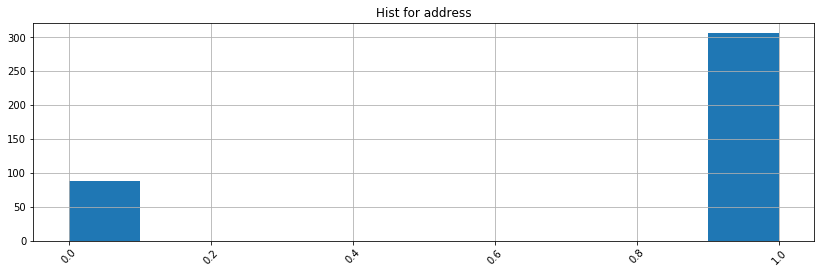

address       1.00
traveltime   -0.30
school        0.30
internet      0.22
age          -0.15
Medu          0.14
score         0.12
failures     -0.12
Name: address, dtype: float64

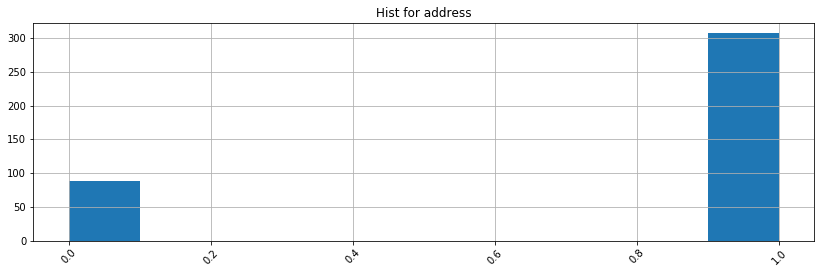

СТАЛО address NaN = 0


In [2651]:
updateFeature(targetFeatureIn = 'address',filter4TargetGroupIn = '(traveltime == 2 ) & (school == 1) & (internet == 1) & ( Medu == 4)  ', filterQueryIn = '(traveltime == 2 ) & (school == 1) & (internet == 1) & ( Medu == 4) ', funcIn = 'mostfreq', N_featuresIn = 'all', displayHist=True )

In [2652]:
if len(df[pd.isna(df[targetFeature])].index) == 0 : print(f'Все NaN в "{targetFeature}" успешно заменены.')

Все NaN в "address" успешно заменены.


--------------------------------------------------------
#  Устраняем NaN в Medu

In [2653]:
targetFeature = 'Medu'
getCorrelationFeatures(col=targetFeature, df1=df)

Medu          1.00
Fedu          0.63
failures     -0.24
score         0.22
internet      0.21
famsup        0.20
nursery       0.19
higher        0.18
paid          0.18
traveltime   -0.17
age          -0.16
address       0.14
Pstatus      -0.13
school        0.13
activities    0.11
absences      0.10
Name: Medu, dtype: float64

In [2654]:
df[pd.isna(df[targetFeature])].groupby([ 'Fedu', 'failures', 'score'])['age'].count()

Fedu  failures  score
2.0   1.0       0.0      1
3.0   0.0       50.0     1
Name: age, dtype: int64

In [2655]:
df[pd.isna(df[targetFeature])]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
193,1,1,16,0.0,1.0,NaN,NaN,3.0,services,services,reputation,mother,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,-3.0,1.0,1.0,0.0,4.0,3.0,2.0,5.0,8.0,50.0
239,1,1,18,1.0,1.0,NaN,NaN,2.0,other,services,reputation,father,1.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,-6.0,0.0,NaN,0.0,5.0,5.0,4.0,2.0,0.0,0.0


БЫЛО Medu NaN = 2


Medu          1.00
Fedu          0.63
failures     -0.24
score         0.22
internet      0.21
famsup        0.20
nursery       0.19
higher        0.18
paid          0.18
traveltime   -0.17
age          -0.16
address       0.14
Pstatus      -0.13
school        0.13
activities    0.11
absences      0.10
Name: Medu, dtype: float64

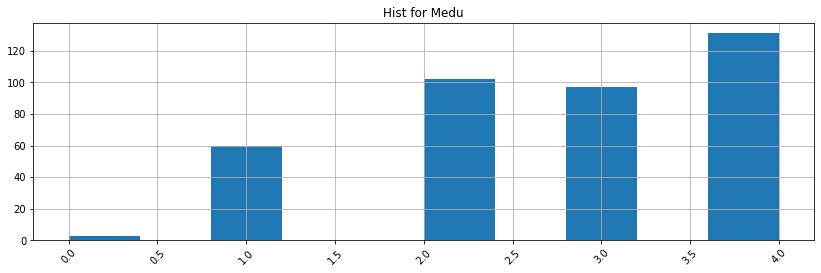

Medu          1.00
Fedu          0.63
failures     -0.24
score         0.22
internet      0.21
famsup        0.20
nursery       0.19
higher        0.18
paid          0.18
traveltime   -0.17
age          -0.16
address       0.14
Pstatus      -0.13
school        0.13
activities    0.11
absences      0.10
Name: Medu, dtype: float64

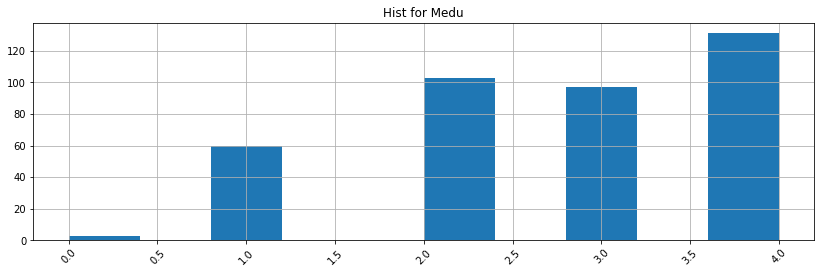

СТАЛО Medu NaN = 1


In [2656]:
updateFeature(targetFeatureIn = 'Medu',filter4TargetGroupIn = '(Fedu == 2 ) & (failures == 1) & (score <= 20) ', filterQueryIn = '(Fedu == 2 ) & (failures == 1) & (score <= 20) ', funcIn = 'mostfreq', N_featuresIn = 'all', displayHist=True )

БЫЛО Medu NaN = 1


Medu          1.00
Fedu          0.63
failures     -0.24
score         0.22
internet      0.21
famsup        0.20
nursery       0.19
higher        0.18
paid          0.18
traveltime   -0.17
age          -0.16
address       0.14
Pstatus      -0.13
school        0.13
activities    0.11
absences      0.10
Name: Medu, dtype: float64

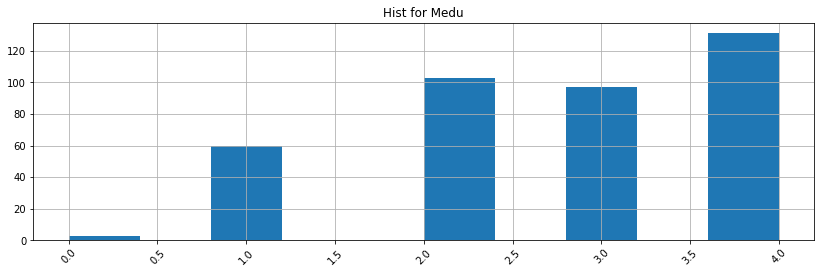

Medu          1.00
Fedu          0.63
failures     -0.24
score         0.22
internet      0.21
famsup        0.20
nursery       0.19
higher        0.18
paid          0.18
traveltime   -0.17
age          -0.16
address       0.14
Pstatus      -0.13
school        0.13
activities    0.11
absences      0.10
Name: Medu, dtype: float64

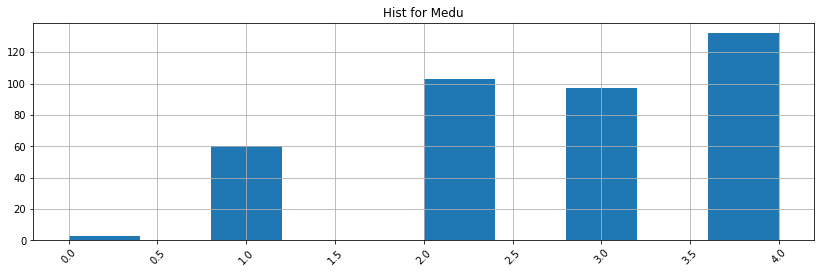

СТАЛО Medu NaN = 0


In [2657]:
updateFeature(targetFeatureIn = 'Medu',filter4TargetGroupIn = '(Fedu == 3 ) & (failures == 0) & (  45 <= score <=65) ', filterQueryIn = '(Fedu == 3 ) & (failures == 0) & (  45 <= score <=65) ', funcIn = 'mostfreq', N_featuresIn = 'all', displayHist=True )

In [2658]:
if len(df[pd.isna(df[targetFeature])].index) == 0 : print(f'Все NaN в "{targetFeature}" успешно заменены.')

Все NaN в "Medu" успешно заменены.


--------------------------------------------------------
#  Устраняем NaN в Pstatus

In [2659]:
df['FamEdu'] = df.apply(lambda x: max(x['Medu'], x['Fedu']), axis=1)
df

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score,FamEdu
0,1,0,18,1.0,1.0,0.0,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,1.0,0.0,0.0,0.0,1.0,-6.0,1.0,NaN,0.0,4.0,3.0,4.0,3.0,6.0,30.0,4.0
1,1,0,17,1.0,1.0,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,-6.0,1.0,1.0,0.0,5.0,3.0,3.0,3.0,4.0,30.0,1.0
2,1,0,15,1.0,0.0,1.0,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,1.0,0.0,NaN,0.0,1.0,-6.0,1.0,1.0,0.0,4.0,3.0,2.0,3.0,10.0,50.0,1.0
3,1,0,15,1.0,1.0,1.0,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,0.0,1.0,1.0,1.0,1.0,-9.0,1.0,1.0,1.0,3.0,2.0,2.0,5.0,2.0,75.0,4.0
4,1,0,16,1.0,1.0,1.0,3.0,3.0,other,other,home,father,1.0,2.0,0.0,0.0,1.0,1.0,0.0,1.0,-6.0,1.0,0.0,0.0,4.0,3.0,2.0,5.0,4.0,50.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,0,1,20,1.0,0.0,0.0,2.0,2.0,services,services,course,NaN,1.0,2.0,2.0,0.0,1.0,1.0,0.0,1.0,-6.0,1.0,0.0,0.0,5.0,5.0,4.0,4.0,4.0,45.0,2.0
391,0,1,17,1.0,0.0,1.0,3.0,1.0,services,services,course,mother,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,-3.0,1.0,1.0,0.0,2.0,4.0,5.0,2.0,3.0,80.0,3.0
392,0,1,21,0.0,1.0,1.0,1.0,1.0,other,other,course,NaN,1.0,1.0,3.0,NaN,0.0,0.0,0.0,0.0,-3.0,NaN,0.0,0.0,5.0,5.0,3.0,3.0,3.0,35.0,1.0
393,0,1,18,0.0,0.0,1.0,3.0,2.0,services,other,course,mother,3.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,-3.0,1.0,1.0,0.0,4.0,4.0,1.0,5.0,0.0,50.0,3.0


In [2660]:
targetFeature = 'Pstatus'
getCorrelationFeatures(col=targetFeature, df1=df)

Pstatus       1.00
absences     -0.16
FamEdu       -0.13
Medu         -0.13
Fedu         -0.11
activities    0.10
Name: Pstatus, dtype: float64

In [2661]:
dfNaNpstatus = df[pd.isna(df[targetFeature])].groupby([ 'absences', 'FamEdu', 'famrel', 'guardian'])['age'].count().to_frame(name="count").reset_index()
dfNaNpstatus

,absences,FamEdu,famrel,guardian,count
0,0.0,1.0,4.0,mother,1
1,0.0,2.0,4.0,mother,1
2,0.0,2.0,4.0,other,1
3,0.0,2.0,5.0,father,1
4,0.0,3.0,4.0,mother,1
5,0.0,4.0,4.0,father,1
6,0.0,4.0,4.0,mother,1
7,0.0,4.0,5.0,father,1
8,1.0,1.0,5.0,mother,1
9,2.0,2.0,3.0,mother,1


In [2662]:
targetFeature = 'Pstatus'
dfNaNpstatus = df[pd.isna(df[targetFeature])].groupby([ 'absences', 'FamEdu', 'famrel', 'guardian'])['age'].count().to_frame(name="count").reset_index()
for index, row in dfNaNpstatus.iterrows():
    filterS= f' ({row.absences -3} <= absences <= {row.absences +3}) & (FamEdu == {row.FamEdu}) & (famrel == {row.famrel}) & (guardian == "{row.guardian}")'
    print(filterS)
    res= calcNumbFeature(groupbyList=['Pstatus', 'absences', 'FamEdu', 'famrel', 'guardian'], filterQuery=filterS, targetFeature=targetFeature,  func='mostfreq', silent=False)
    print(res)

(-3.0 <= absences <= 3.0) & (FamEdu == 1.0) & (famrel == 4.0) & (guardian == "mother")
Выбрано 2 строк; Случаев 7; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
31,1.0,0.0,1.0,4.0,mother,2
58,1.0,2.0,1.0,4.0,mother,5


-------------------------------------------------------
[1.]
 (-3.0 <= absences <= 3.0) & (FamEdu == 2.0) & (famrel == 4.0) & (guardian == "mother")
Выбрано 2 строк; Случаев 14; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
37,1.0,0.0,2.0,4.0,mother,7
61,1.0,2.0,2.0,4.0,mother,7


-------------------------------------------------------
[1.]
 (-3.0 <= absences <= 3.0) & (FamEdu == 2.0) & (famrel == 4.0) & (guardian == "other")
Выбрано 3 строк; Случаев 2; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
2,0.0,0.0,2.0,4.0,other,1
38,1.0,0.0,2.0,4.0,other,1
73,1.0,3.0,2.0,4.0,other,1


-------------------------------------------------------
[1.]
 (-3.0 <= absences <= 3.0) & (FamEdu == 2.0) & (famrel == 5.0) & (guardian == "father")
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count


-------------------------------------------------------
[1.]
 (-3.0 <= absences <= 3.0) & (FamEdu == 3.0) & (famrel == 4.0) & (guardian == "mother")
Выбрано 3 строк; Случаев 7; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
42,1.0,0.0,3.0,4.0,mother,4
64,1.0,2.0,3.0,4.0,mother,2
76,1.0,3.0,3.0,4.0,mother,1


-------------------------------------------------------
[1.]
 (-3.0 <= absences <= 3.0) & (FamEdu == 4.0) & (famrel == 4.0) & (guardian == "father")
Выбрано 2 строк; Случаев 9; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
50,1.0,0.0,4.0,4.0,father,5
67,1.0,2.0,4.0,4.0,father,4


-------------------------------------------------------
[1.]
 (-3.0 <= absences <= 3.0) & (FamEdu == 4.0) & (famrel == 4.0) & (guardian == "mother")
Выбрано 4 строк; Случаев 19; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
5,0.0,0.0,4.0,4.0,mother,1
51,1.0,0.0,4.0,4.0,mother,9
68,1.0,2.0,4.0,4.0,mother,9
77,1.0,3.0,4.0,4.0,mother,1


-------------------------------------------------------
[1.]
 (-3.0 <= absences <= 3.0) & (FamEdu == 4.0) & (famrel == 5.0) & (guardian == "father")
Выбрано 2 строк; Случаев 3; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
52,1.0,0.0,4.0,5.0,father,2
69,1.0,2.0,4.0,5.0,father,1


-------------------------------------------------------
[1.]
 (-2.0 <= absences <= 4.0) & (FamEdu == 1.0) & (famrel == 5.0) & (guardian == "mother")
Выбрано 2 строк; Случаев 3; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
34,1.0,0.0,1.0,5.0,mother,2
81,1.0,4.0,1.0,5.0,mother,1


-------------------------------------------------------
[1.]
 (-1.0 <= absences <= 5.0) & (FamEdu == 2.0) & (famrel == 3.0) & (guardian == "mother")
Выбрано 5 строк; Случаев 7; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
1,0.0,0.0,2.0,3.0,mother,1
36,1.0,0.0,2.0,3.0,mother,2
60,1.0,2.0,2.0,3.0,mother,2
71,1.0,3.0,2.0,3.0,mother,1
82,1.0,4.0,2.0,3.0,mother,2


-------------------------------------------------------
[1.]
 (-1.0 <= absences <= 5.0) & (FamEdu == 2.0) & (famrel == 4.0) & (guardian == "mother")
Выбрано 4 строк; Случаев 18; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
37,1.0,0.0,2.0,4.0,mother,7
61,1.0,2.0,2.0,4.0,mother,7
84,1.0,4.0,2.0,4.0,mother,2
101,1.0,5.0,2.0,4.0,mother,2


-------------------------------------------------------
[1.]
 (-1.0 <= absences <= 5.0) & (FamEdu == 3.0) & (famrel == 1.0) & (guardian == "mother")
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count


-------------------------------------------------------
[1.]
 (-1.0 <= absences <= 5.0) & (FamEdu == 3.0) & (famrel == 5.0) & (guardian == "mother")
Выбрано 3 строк; Случаев 6; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
44,1.0,0.0,3.0,5.0,mother,4
54,1.0,1.0,3.0,5.0,mother,1
93,1.0,4.0,3.0,5.0,mother,1


-------------------------------------------------------
[1.]
 (-1.0 <= absences <= 5.0) & (FamEdu == 4.0) & (famrel == 3.0) & (guardian == "mother")
Выбрано 4 строк; Случаев 5; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
7,0.0,2.0,4.0,3.0,mother,1
49,1.0,0.0,4.0,3.0,mother,3
66,1.0,2.0,4.0,3.0,mother,1
96,1.0,4.0,4.0,3.0,mother,1


-------------------------------------------------------
[1.]
 (1.0 <= absences <= 7.0) & (FamEdu == 1.0) & (famrel == 5.0) & (guardian == "father")
Выбрано 1 строк; Случаев 1; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
104,1.0,6.0,1.0,5.0,father,1


-------------------------------------------------------
[1.]
 (1.0 <= absences <= 7.0) & (FamEdu == 3.0) & (famrel == 4.0) & (guardian == "father")
Выбрано 2 строк; Случаев 4; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
63,1.0,2.0,3.0,4.0,father,1
90,1.0,4.0,3.0,4.0,father,3


-------------------------------------------------------
[1.]
 (1.0 <= absences <= 7.0) & (FamEdu == 3.0) & (famrel == 4.0) & (guardian == "mother")
Выбрано 5 строк; Случаев 6; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
8,0.0,4.0,3.0,4.0,mother,1
64,1.0,2.0,3.0,4.0,mother,2
76,1.0,3.0,3.0,4.0,mother,1
91,1.0,4.0,3.0,4.0,mother,1
110,1.0,6.0,3.0,4.0,mother,2


-------------------------------------------------------
[1.]
 (1.0 <= absences <= 7.0) & (FamEdu == 4.0) & (famrel == 4.0) & (guardian == "mother")
Выбрано 6 строк; Случаев 18; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
12,0.0,6.0,4.0,4.0,mother,2
68,1.0,2.0,4.0,4.0,mother,9
77,1.0,3.0,4.0,4.0,mother,1
98,1.0,4.0,4.0,4.0,mother,5
115,1.0,6.0,4.0,4.0,mother,2
117,1.0,7.0,4.0,4.0,mother,1


-------------------------------------------------------
[1.]
 (1.0 <= absences <= 7.0) & (FamEdu == 4.0) & (famrel == 5.0) & (guardian == "father")
Выбрано 2 строк; Случаев 1; Значение для Pstatus=[0. 1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
13,0.0,6.0,4.0,5.0,father,1
69,1.0,2.0,4.0,5.0,father,1


-------------------------------------------------------
[0. 1.]
 (1.0 <= absences <= 7.0) & (FamEdu == 4.0) & (famrel == 5.0) & (guardian == "mother")
Выбрано 4 строк; Случаев 9; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
14,0.0,6.0,4.0,5.0,mother,1
70,1.0,2.0,4.0,5.0,mother,3
99,1.0,4.0,4.0,5.0,mother,5
118,1.0,7.0,4.0,5.0,mother,1


-------------------------------------------------------
[1.]
 (3.0 <= absences <= 9.0) & (FamEdu == 2.0) & (famrel == 3.0) & (guardian == "mother")
Выбрано 3 строк; Случаев 4; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
71,1.0,3.0,2.0,3.0,mother,1
82,1.0,4.0,2.0,3.0,mother,2
122,1.0,8.0,2.0,3.0,mother,1


-------------------------------------------------------
[1.]
 (3.0 <= absences <= 9.0) & (FamEdu == 2.0) & (famrel == 4.0) & (guardian == "mother")
Выбрано 4 строк; Случаев 9; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
84,1.0,4.0,2.0,4.0,mother,2
101,1.0,5.0,2.0,4.0,mother,2
106,1.0,6.0,2.0,4.0,mother,3
123,1.0,8.0,2.0,4.0,mother,2


-------------------------------------------------------
[1.]
 (3.0 <= absences <= 9.0) & (FamEdu == 3.0) & (famrel == 5.0) & (guardian == "mother")
Выбрано 3 строк; Случаев 4; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
93,1.0,4.0,3.0,5.0,mother,1
116,1.0,7.0,3.0,5.0,mother,2
127,1.0,8.0,3.0,5.0,mother,1


-------------------------------------------------------
[1.]
 (3.0 <= absences <= 9.0) & (FamEdu == 4.0) & (famrel == 1.0) & (guardian == "father")
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count


-------------------------------------------------------
[1.]
 (5.0 <= absences <= 11.0) & (FamEdu == 3.0) & (famrel == 3.0) & (guardian == "father")
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count


-------------------------------------------------------
[1.]
 (5.0 <= absences <= 11.0) & (FamEdu == 4.0) & (famrel == 4.0) & (guardian == "mother")
Выбрано 5 строк; Случаев 5; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
12,0.0,6.0,4.0,4.0,mother,2
115,1.0,6.0,4.0,4.0,mother,2
117,1.0,7.0,4.0,4.0,mother,1
129,1.0,8.0,4.0,4.0,mother,1
138,1.0,10.0,4.0,4.0,mother,1


-------------------------------------------------------
[1.]
 (7.0 <= absences <= 13.0) & (FamEdu == 3.0) & (famrel == 4.0) & (guardian == "other")
Выбрано 1 строк; Случаев 1; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
126,1.0,8.0,3.0,4.0,other,1


-------------------------------------------------------
[1.]
 (8.0 <= absences <= 14.0) & (FamEdu == 4.0) & (famrel == 4.0) & (guardian == "mother")
Выбрано 5 строк; Случаев 4; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count
22,0.0,12.0,4.0,4.0,mother,1
23,0.0,14.0,4.0,4.0,mother,1
129,1.0,8.0,4.0,4.0,mother,1
138,1.0,10.0,4.0,4.0,mother,1
157,1.0,14.0,4.0,4.0,mother,2


-------------------------------------------------------
[1.]
 (11.0 <= absences <= 17.0) & (FamEdu == 2.0) & (famrel == 1.0) & (guardian == "mother")
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count


-------------------------------------------------------
[1.]
 (15.0 <= absences <= 21.0) & (FamEdu == 1.0) & (famrel == 3.0) & (guardian == "mother")
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count


-------------------------------------------------------
[1.]
 (18.0 <= absences <= 24.0) & (FamEdu == 4.0) & (famrel == 3.0) & (guardian == "father")
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count


-------------------------------------------------------
[1.]
 (21.0 <= absences <= 27.0) & (FamEdu == 4.0) & (famrel == 4.0) & (guardian == "mother")
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count


-------------------------------------------------------
[1.]
 (35.0 <= absences <= 41.0) & (FamEdu == 4.0) & (famrel == 4.0) & (guardian == "other")
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count


-------------------------------------------------------
[1.]
 (53.0 <= absences <= 59.0) & (FamEdu == 3.0) & (famrel == 5.0) & (guardian == "mother")
Ничего не нашли похожего
Выбрано 0 строк; Случаев 0; Значение для Pstatus=[1.]


,Pstatus,absences,FamEdu,famrel,guardian,count


-------------------------------------------------------
[1.]


In [2663]:
dfNaNpstatus

,absences,FamEdu,famrel,guardian,count
0,0.0,1.0,4.0,mother,1
1,0.0,2.0,4.0,mother,1
2,0.0,2.0,4.0,other,1
3,0.0,2.0,5.0,father,1
4,0.0,3.0,4.0,mother,1
5,0.0,4.0,4.0,father,1
6,0.0,4.0,4.0,mother,1
7,0.0,4.0,5.0,father,1
8,1.0,1.0,5.0,mother,1
9,2.0,2.0,3.0,mother,1


------------------------------------------------------------


In [2664]:
df0=pd.get_dummies(df[['Pstatus','absences', 'FamEdu','guardian', 'romantic', 'famrel',
       'freetime', 'goout', 'health', 'score']])

df0['guardian_father'].fillna( method ='bfill', inplace = True) 
df0[['guardian_father', 'guardian_mother', 'guardian_other']].fillna( method ='bfill', inplace = True) 
df0

,Pstatus,absences,FamEdu,romantic,famrel,freetime,goout,health,score,guardian_father,guardian_mother,guardian_other
0,0.0,6.0,4.0,0.0,4.0,3.0,4.0,3.0,30.0,0,1,0
1,NaN,4.0,1.0,0.0,5.0,3.0,3.0,3.0,30.0,1,0,0
2,1.0,10.0,1.0,0.0,4.0,3.0,2.0,3.0,50.0,0,1,0
3,1.0,2.0,4.0,1.0,3.0,2.0,2.0,5.0,75.0,0,1,0
4,1.0,4.0,3.0,0.0,4.0,3.0,2.0,5.0,50.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
390,0.0,4.0,2.0,0.0,5.0,5.0,4.0,4.0,45.0,0,0,0
391,1.0,3.0,3.0,0.0,2.0,4.0,5.0,2.0,80.0,0,1,0
392,1.0,3.0,1.0,0.0,5.0,5.0,3.0,3.0,35.0,0,0,0
393,1.0,0.0,3.0,0.0,4.0,4.0,1.0,5.0,50.0,0,1,0


In [2665]:
rr=abs(df0.corr()['Pstatus'])
rr[rr>0.1]

Pstatus     1.000000
absences    0.163205
FamEdu      0.133184
Name: Pstatus, dtype: float64

In [2666]:
getCorrelationFeatures(col='guardian_other', df1=df0)

guardian_other     1.00
guardian_mother   -0.36
guardian_father   -0.15
absences           0.14
romantic           0.13
FamEdu            -0.13
Name: guardian_other, dtype: float64

In [2667]:
#sns.pairplot(df, kind = 'reg')

In [2668]:
#df.loc[(pd.isna(df.famsize)) & ( df.Pstatus == 'T')  ,'famsize'] ='GT3'
#df.loc[(pd.isna(df.famsize)) & ( df.Pstatus == 'T')]


In [2669]:
# df1=pd.get_dummies(df[['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
#        'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
#        'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
#        'studytime, granular', 'higher', 'internet', 'romantic', 'famrel',
#        'freetime', 'goout', 'health', 'absences', 'score']])
# df1

In [2670]:
# # df.Fjob.fillna(method='backfill', axis=0, inplace=True)
# df.fillna(method='backfill', axis=0, inplace=True)
# for col in [	'Fjob',	'reason',	'guardian',	'traveltime',	'studytime',	'failures',	'schoolsup',	'famsup',	'paid',	'activities',	'nursery',	'higher',	'internet',	'romantic',	'famrel', 'freetime',	'goout',	'health','Mjob',	'absences']:
#     get_stat_dif(col)

In [2671]:
# changeVal(['schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher','internet',	'romantic'],'yes',1,'no',0)
# changeVal(['famsize'],'LE3',0,'GT3',1)
# changeVal(['Pstatus'],'T',1,'A',0)
# changeVal(['address'],'U',1,'R',0)

In [2672]:
# for col in df.columns: # ['school',	'sex',	'age',	'address',	'famsize',	'Pstatus',	'Medu',	'Fedu',	'Mjob',	'Fjob',	'reason',	'guardian',	'traveltime',	'studytime',	'failures',	'schoolsup',	'famsup',	'paid',	'activities',	'nursery',	'higher',	'internet',	'romantic',	'famrel', 'freetime',	'goout',	'health',	'absences']:
#      get_boxplot(col)	
    	

In [2673]:
#df.loc[pd.isna(df.address)]

In [2674]:
for col in [	'Fjob',	'reason',	'guardian',	'traveltime',	'studytime',	'failures',	'schoolsup',	'famsup',	'paid',	'activities',	'nursery',	'higher',	'internet',	'romantic',	'famrel', 'freetime',	'goout',	'health','Mjob',	'absences']:
    get_stat_dif(col)

Найдены статистически значимые различия для колонки Mjob


In [2675]:
df.Mjob.value_counts()


other       133
services     98
at_home      58
teacher      55
health       32
Name: Mjob, dtype: int64